In [2]:
RANDOM_SEED = 2117
TEST_SET_PROP = 0.2

import os
import pandas as pd
import numpy as np
from collections import Counter
from math import sqrt
from sklearn.metrics import confusion_matrix, roc_auc_score, average_precision_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import catboost as cb
import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN, BorderlineSMOTE, KMeansSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

def compute_imbalace( y ):
    y_counts = Counter( y )
    return (y_counts[ 0 ]/y_counts[ 1 ])

def compute_metrics(y, pred_class, pred_proba):
    t0, f1, f0, t1 = confusion_matrix(y, pred_class).ravel()
    acc0 = t0/(t0 + f1)
    acc1 = t1/(t1 + f0)
    g_mean = sqrt(acc0*acc1)
    prec0 = t0/(t0 + f0)
    prec1 = t1/(t1 + f1)
    f_sc = 2*prec1*acc1/(prec1+acc1)
    auc = roc_auc_score(y, pred_proba)
    auc_pr = average_precision_score(y, pred_proba)
    return([100*acc0, 100*acc1, 100*g_mean, 100*f_sc, 100*prec1, 100*auc, 100*auc_pr])

def svm_compute_metrics(y, pred_class):
    t0, f1, f0, t1 = confusion_matrix(y, pred_class).ravel()
    acc0 = t0/(t0 + f1)
    acc1 = t1/(t1 + f0)
    g_mean = sqrt(acc0*acc1)
    prec1 = t1/(t1 + f1)
    f_sc = 2*prec1*acc1/(prec1+acc1)
    return([100*acc0, 100*acc1, 100*g_mean, 100*f_sc, 100*prec1, 0, 0])

col = ['clf',  'ir_chunk', 'Acc-', 'Acc+', 'Gmean', 'F-Score', 'prec1', 'auc', 'auc_pr']

def compute_performance_df ( all_results, IR_chunk, type_ , dataset_name, clf_list, clf_names ):
    results_mat = []
    for i, c in enumerate(clf_list):
        for j, ir in enumerate(IR_chunk):
            indices = [v+j for v in range(0, len(IR_chunk)*(n_iter-1)+1, len(IR_chunk))]
            temp = np.array([all_results[t][i] for t in indices])
            avg = np.mean(temp, axis = 0)
            sd = np.std(temp, axis = 0)
            a = [clf_names[i], '{:3.2f}'.format(ir)]
            a = a + ['{:2.2f} ({:2.2f})'.format(i, j) for i,j in list(zip(avg, sd))]
            results_mat.append(a)
    print(results_mat)
    print(col)
    dat = pd.DataFrame(results_mat, columns = ['clf',  'ir_chunk', 'Acc-', 'Acc+', 'Gmean', 'F-Score', 'prec1', 'auc', 'auc_pr'])
    dat.to_excel(f'{path_to_save_results}/{type_}.xlsx') 

def raw_performance( X, y, dataset_name, type_, clf_list, clf_names ):
    all_results = []
    for i, s in enumerate(seed_):
        for _ in [1]:
            X_train, X_test, y_train, y_test  = train_test_split(X, y, stratify=y, test_size=TEST_SET_PROP, random_state = s)
            clf_results = []
            for clf in clf_list:
                if ( isinstance(clf, LogisticRegression) or isinstance(clf, SGDClassifier) ) or isinstance(clf, MLPClassifier):
                    preprocessor = ColumnTransformer(transformers=[('num', StandardScaler(), columns_to_scale)])
                    pipe = Pipeline(steps = [('scaler', preprocessor), ('rf',clf)])
                else:
                    pipe = Pipeline(steps = [('rf',clf)])
                pipe.fit(X_train, y_train)
                predictions = pipe.predict(X_test)
                if isinstance(clf, SGDClassifier):
                    a = svm_compute_metrics(y_test, predictions)
                else:
                    prob_predictions = pipe.predict_proba(X_test)[:,1] #classes are 0-1
                    a = compute_metrics(y_test, predictions, prob_predictions)
                print(a)
                clf_results.append(a)
            all_results.append(clf_results)
    v = [1]
    compute_performance_df( all_results, v, type_, dataset_name, clf_list, clf_names )
    return (None)


def resampled_performance( X, y, dataset_name, type_, methods, clf_list, clf_names ):
    all_results = []
    for i, s in enumerate(seed_):
        for IR in IR_chunk:
            if 'sampling_strategy' in methods[type_].get_params():
                methods[type_].set_params(**{'sampling_strategy':1/IR})
            X_train, X_test, y_train, y_test  = train_test_split(X, y, stratify=y, test_size=TEST_SET_PROP, random_state = s)
            clf_results = []
            for clf in clf_list:
                if ( isinstance(clf, LogisticRegression) or isinstance(clf, SGDClassifier) ) or isinstance(clf, MLPClassifier):
                    preprocessor = ColumnTransformer(transformers=[('num', StandardScaler(), columns_to_scale)])
                    pipe = imbpipeline(steps = [('mthod', methods[type_]), ('scaler', preprocessor), ('rf',clf)])
                else:
                    pipe = imbpipeline(steps = [('mthod', methods[type_]), ('rf',clf)])
                pipe.fit(X_train, y_train)
                predictions = pipe.predict(X_test)
                if isinstance(clf, SGDClassifier):
                    a = svm_compute_metrics(y_test, predictions)
                else:
                    prob_predictions = pipe.predict_proba(X_test)[:,1] #classes are 0-1
                    a = compute_metrics(y_test, predictions, prob_predictions)
                print(a)
                clf_results.append(a)
            all_results.append(clf_results)
    compute_performance_df( all_results, IR_chunk, type_, dataset_name, clf_list, clf_names )
    return (None)

def enn_performance( X, y, dataset_name, type_, clf_list, clf_names ):
    all_results = []
    for i, s in enumerate(seed_):
        for _ in [1]:
            X_train, X_test, y_train, y_test  = train_test_split(X, y, stratify=y, test_size=TEST_SET_PROP, random_state = s)
            clf_results = []
            for clf in clf_list:
                if ( isinstance(clf, LogisticRegression) or isinstance(clf, SGDClassifier) ) or isinstance(clf, MLPClassifier):
                    preprocessor = ColumnTransformer(transformers=[('num', StandardScaler(), columns_to_scale)])
                    pipe = imbpipeline(steps = [('method', EditedNearestNeighbours()), ('scaler', preprocessor), ('rf',clf)])
                else:
                    pipe = imbpipeline(steps = [('method', EditedNearestNeighbours()), ('rf',clf)])
                pipe.fit(X_train, y_train)
                predictions = pipe.predict(X_test)
                if isinstance(clf, SGDClassifier):
                    a = svm_compute_metrics(y_test, predictions)
                else:
                    prob_predictions = pipe.predict_proba(X_test)[:,1] #classes are 0-1
                    a = compute_metrics(y_test, predictions, prob_predictions)
                print(a)
                clf_results.append(a)
            all_results.append(clf_results)
    v = [1]
    compute_performance_df( all_results, v, type_, dataset_name, clf_list, clf_names )
    return (None)

def ensemble_performance( X, y, dataset_name, type_, clf_list, clf_names ):
    all_results = []
    actual_IR_list = []
    for i, s in enumerate(seed_):
        for IR in IR_chunk:
            ##########################
            # create the chunks
            y_counts = Counter(y)
            maj_count = y_counts[0]
            min_count = y_counts[1]
            IR_initial = maj_count/min_count
    
            sss = StratifiedShuffleSplit(n_splits=1, test_size=TEST_SET_PROP, random_state=s)
            for _, (train_index, test_index) in enumerate(sss.split(X, y)):
                pass

            minority_indices = [i for i in train_index if (y[i] == 1)]
            majority_indices = [i for i in train_index if (y[i] == 0)]
    
            num_chunks = int(IR_initial/IR) 
            splits = np.array_split(majority_indices, num_chunks)
            IR_chunk_actual = len(splits[0])/len(minority_indices) #other split will give very close IR
            if IR_chunk_actual not in actual_IR_list:
                actual_IR_list.append(IR_chunk_actual)
            ##########################
            clf_results = []
            for clf in clf_list:
                ########### create voting classifier
                ########### store predictions, prob_predictions
                predictions = [1 for i in range(num_chunks)]
                prob_predictions = [1 for i in range(num_chunks)]

                for i in range(num_chunks):
                    train_indices = minority_indices + splits[i].tolist()
                    X_train = X.iloc[train_indices]
                    y_train = y[train_indices]
                    X_test = X.iloc[test_index]
                    y_test = y[test_index]
                    if ( isinstance(clf, LogisticRegression) or isinstance(clf, SGDClassifier) ) or isinstance(clf, MLPClassifier):
                        preprocessor = ColumnTransformer(transformers=[('num', StandardScaler(), columns_to_scale)])
                        pipe = imbpipeline(steps = [('scaler', preprocessor), ('rf',clf)])
                    else:
                        pipe = imbpipeline(steps = [('rf',clf)])
                    pipe.fit(X_train, y_train)
                    predictions[i] = pipe.predict(X_test)
                    if not isinstance(clf, SGDClassifier):
                        prob_predictions[i] = pipe.predict_proba(X_test)[:,1]
                    print(f'{i}/{num_chunks}')

                combined_prediction = [Counter([predictions[i][j] for i in range(num_chunks)]).most_common(1)[0][0] for j in range(len(predictions[0]))]
                if isinstance(clf, SGDClassifier):
                    a = svm_compute_metrics(y_test, combined_prediction)
                else:
                    combined_prob_prediction = [np.mean([prob_predictions[i][j] for i in range(num_chunks)]) for j in range(len(predictions[0]))]
                    a = compute_metrics(y_test, combined_prediction, combined_prob_prediction)
                    
                print(a)
                clf_results.append(a)
            all_results.append(clf_results)
    compute_performance_df( all_results, actual_IR_list, type_, dataset_name, clf_list, clf_names )
    return (None)

def kmeans_bsmote( X, y, dataset_name, type_, clf_list, clf_names, n_clusters = 3  ):
    all_results = []
    for i, s in enumerate(seed_):
        for IR in IR_chunk:
            final_IR = IR
            ##########################
            k = 5
            neigh = NearestNeighbors(n_neighbors=k)
            X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=TEST_SET_PROP, random_state = s)
            neigh.fit(X_train.values)

            majority_indices = [i for i, c in enumerate(y_train) if c== 0]
            minority_indices = [i for i, c in enumerate(y_train) if c== 1]
            noisy_minority = [i for i in minority_indices if (np.sum(y_train.iloc[neigh.kneighbors([X_train.iloc[i]])[1][0]]) == 0)]
            safe_minority =  [i for i in minority_indices if (np.sum(y_train.iloc[neigh.kneighbors([X_train.iloc[i]])[1][0]]) == k)]
            borderline_minority = [i for i in minority_indices if i not in (noisy_minority+safe_minority)]
            non_noisy_minority = safe_minority+borderline_minority
            non_noisy_minority_data = X_train.iloc[borderline_minority]

            kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(non_noisy_minority_data)

            y_train.iloc[borderline_minority] = 1+kmeans.labels_
            y_train.iloc[noisy_minority+safe_minority] = 1 + n_clusters

            sampling_strat = {0: len(majority_indices), (1 + n_clusters):(len(noisy_minority+safe_minority))}
            v = Counter(kmeans.labels_)
            for cluster in v.keys():
                sampling_strat[1+cluster] = v[cluster] + int((initial_IR/final_IR - 1)*len(minority_indices)*v[cluster]/len(borderline_minority))

            X_res, y_res = SMOTE(random_state=RANDOM_SEED, sampling_strategy = sampling_strat).fit_resample(X_train, y_train)
            y_res.iloc[np.where(y_res > 0)] = 1
            print(Counter(y_res))
            ##########################
            clf_results = []
            for clf in clf_list:
                if ( isinstance(clf, LogisticRegression) or isinstance(clf, SGDClassifier) ) or isinstance(clf, MLPClassifier):
                        preprocessor = ColumnTransformer(transformers=[('num', StandardScaler(), columns_to_scale)])
                        pipe = imbpipeline(steps = [('scaler', preprocessor), ('rf',clf)])
                else:
                    pipe = imbpipeline(steps = [('rf',clf)])
                pipe.fit(X_res, y_res)
                predictions = pipe.predict(X_test)
                
                if isinstance(clf, SGDClassifier):
                    a = svm_compute_metrics(y_test, predictions)
                else:
                    prob_predictions = pipe.predict_proba(X_test)[:,1]
                    a = compute_metrics(y_test, predictions, prob_predictions)  
                #print(a)
                clf_results.append(a)
            all_results.append(clf_results)
    print(all_results, IR_chunk, type_, dataset_name, clf_list, clf_names)
    compute_performance_df( all_results, IR_chunk, type_, dataset_name, clf_list, clf_names )
    return (None)


clf_names = ['rf', 'xgb', 'svm', 'mlp', 'logistic', 'cat', 'lgbm'] #####

clf_list = [RandomForestClassifier(random_state = RANDOM_SEED,     #####
                                   max_depth = 5, 
                                   max_features = 'sqrt', 
                                   bootstrap = True, 
                                   n_jobs = -1, 
                                   n_estimators = 100),
            xgb.XGBClassifier(random_state = RANDOM_SEED, max_depth = 5, n_jobs = -1),
            SGDClassifier(random_state = RANDOM_SEED, n_jobs=-1),
            MLPClassifier(hidden_layer_sizes=(5,), 
                          max_iter=1000, 
                          alpha=1e-4, 
                          activation = 'logistic',
                          solver='sgd', 
                          tol=1e-4, 
                          random_state=RANDOM_SEED,
                          learning_rate_init=.1),
           LogisticRegression(penalty = 'l2',
                         random_state = RANDOM_SEED,
                         max_iter = 1000,
                         solver='lbfgs',
                         n_jobs=-1),
           cb.CatBoostClassifier(
               iterations=1000,
               learning_rate=0.05,
               depth=5,
               eval_metric="F1",
               random_state=RANDOM_SEED),
           lgb.LGBMClassifier(
               n_estimators=100,
               learning_rate=0.05,
               max_depth=5,
               random_state=RANDOM_SEED)]

reduced_clf_names = ['xgb', 'cat', 'lgbm'] #####
reduced_clf_list = [xgb.XGBClassifier(random_state = RANDOM_SEED, max_depth = 5, n_jobs = -1),
           cb.CatBoostClassifier(
               iterations=1000,
               learning_rate=0.05,
               depth=5,
               eval_metric="F1",
               random_state=RANDOM_SEED),
           lgb.LGBMClassifier(
               n_estimators=100,
               learning_rate=0.05,
               max_depth=5,
               random_state=RANDOM_SEED)]



True
(284807, 31)
Counter({0: 284315, 1: 492})
577.8760162601626


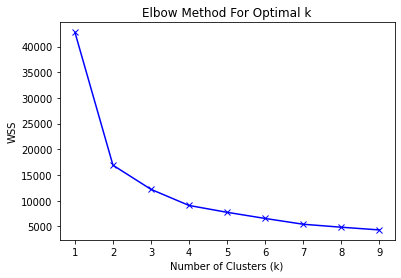

In [6]:
# Belgium Credit Fraud
methods = {'RUS':RandomUnderSampler( random_state=RANDOM_SEED ),
           'SMOTE':SMOTE( random_state=RANDOM_SEED ),
           'ROS':RandomOverSampler( random_state=RANDOM_SEED ),
           'BSMOTE':BorderlineSMOTE( random_state=RANDOM_SEED ),
           'ADASYN':ADASYN( random_state=RANDOM_SEED )} # cannot be used on Taiwan Data, so use only on Belgian Credit

path_to_data = 'D:/data-sets-and-code/creditcard.csv'
dataset_name = 'credit_Belgium'  ##### new name for each dataset
path_to_save_results = f'D:/{dataset_name}' ###### ensure directory exists
print ( os.path.isdir(path_to_save_results) ) ####### must return True

df = pd.read_csv(path_to_data)
print(df.shape)

X = df.drop(['Class'], axis = 1)
y = df['Class'].astype('int').values

print(Counter( y )) #check 0 maj, 1 min ###############
print(compute_imbalace( y ))
ir = compute_imbalace( y )

initial_IR = ir
IR_chunk = [100, 50, 20, 2]        ##### specify resulting IR in train data
columns_to_scale = X.columns ##### specify columns to scale
n_iter = 10                    ##############
seed_ = [i for i in range(n_iter)]

clf_names_wtd = ['rf', 'xgb', 'svm', 'logistic', 'cat', 'lgbm'] #####
clf_list_wtd = [RandomForestClassifier(random_state = RANDOM_SEED,     #####
                                   max_depth = 5, 
                                   max_features = 'sqrt', 
                                   bootstrap = True, 
                                   n_jobs = -1,
                                   class_weight= 'balanced', 
                                   n_estimators = 100),
            xgb.XGBClassifier(random_state = RANDOM_SEED, max_depth = 5, n_jobs = -1,
                               scale_pos_weight = ir),
            SGDClassifier(random_state = RANDOM_SEED, n_jobs=-1, class_weight= 'balanced'),
            LogisticRegression(penalty = 'l2',
                         random_state = RANDOM_SEED,
                         max_iter = 1000,
                         solver='lbfgs',
                         class_weight= 'balanced',
                         n_jobs=-1),
            cb.CatBoostClassifier(
               iterations=1000,
               learning_rate=0.05,
               depth=5,
               eval_metric="F1",
               scale_pos_weight = ir,
               random_state=RANDOM_SEED),
            lgb.LGBMClassifier(
               n_estimators=100,
               learning_rate=0.05,
               class_weight= 'balanced',
               max_depth=5,
               random_state=RANDOM_SEED)]


############## estimate n_clusters #####################################
# Define a range of cluster numbers to try
clusters = range(1,10)

# Initialize an array to store the WSS values for each cluster
wss_values = []

# Calculate the WSS values for each cluster
for k in clusters:
    kmeans_model = KMeans(n_clusters=k).fit(X)
    wss_values.append(sum(np.min(cdist(X, kmeans_model.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the WSS values against the number of clusters
plt.plot(clusters, wss_values, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WSS')
plt.title('Elbow Method For Optimal k')
plt.show()
num_clusters = 3             ##### specify num of minority data clusters, play around with diff values
##########################################################################

In [7]:
ensemble_performance( X, y, dataset_name, 'ensemble', reduced_clf_list, reduced_clf_names)
# kmeans_bsmote( X, y, dataset_name, 'cluster_bsmote', clf_list, clf_names, n_clusters = 3  )
# raw_performance( X, y, dataset_name, 'raw', clf_list, clf_names)
# raw_performance( X, y, dataset_name, 'wtd', clf_list_wtd, clf_names_wtd)
# for type_ in list(methods.keys()):
#     resampled_performance( X, y, dataset_name, type_, methods, clf_list, clf_names )

0/5
1/5
2/5
3/5
4/5
[99.98417276308385, 79.59183673469387, 89.20719676468258, 84.32432432432432, 89.65517241379311, 98.04888929404063, 84.26004650265371]
0:	learn: 0.8190743	total: 192ms	remaining: 3m 11s
1:	learn: 0.7880597	total: 229ms	remaining: 1m 54s
2:	learn: 0.8134111	total: 275ms	remaining: 1m 31s
3:	learn: 0.8253968	total: 316ms	remaining: 1m 18s
4:	learn: 0.8326180	total: 354ms	remaining: 1m 10s
5:	learn: 0.8275862	total: 391ms	remaining: 1m 4s
6:	learn: 0.8104956	total: 431ms	remaining: 1m 1s
7:	learn: 0.8258993	total: 465ms	remaining: 57.7s
8:	learn: 0.8392603	total: 502ms	remaining: 55.3s
9:	learn: 0.8507042	total: 538ms	remaining: 53.3s
10:	learn: 0.8539326	total: 576ms	remaining: 51.7s
11:	learn: 0.8571429	total: 608ms	remaining: 50.1s
12:	learn: 0.8635097	total: 645ms	remaining: 49s
13:	learn: 0.8744828	total: 679ms	remaining: 47.8s
14:	learn: 0.8806584	total: 713ms	remaining: 46.8s
15:	learn: 0.8821918	total: 748ms	remaining: 46s
16:	learn: 0.8867667	total: 782ms	remai

165:	learn: 0.9315436	total: 4.81s	remaining: 24.2s
166:	learn: 0.9315436	total: 4.83s	remaining: 24.1s
167:	learn: 0.9315436	total: 4.86s	remaining: 24.1s
168:	learn: 0.9315436	total: 4.88s	remaining: 24s
169:	learn: 0.9315436	total: 4.91s	remaining: 24s
170:	learn: 0.9315436	total: 4.94s	remaining: 23.9s
171:	learn: 0.9315436	total: 4.96s	remaining: 23.9s
172:	learn: 0.9315436	total: 4.99s	remaining: 23.8s
173:	learn: 0.9315436	total: 5.01s	remaining: 23.8s
174:	learn: 0.9315436	total: 5.04s	remaining: 23.7s
175:	learn: 0.9315436	total: 5.06s	remaining: 23.7s
176:	learn: 0.9315436	total: 5.09s	remaining: 23.7s
177:	learn: 0.9315436	total: 5.11s	remaining: 23.6s
178:	learn: 0.9315436	total: 5.14s	remaining: 23.6s
179:	learn: 0.9315436	total: 5.16s	remaining: 23.5s
180:	learn: 0.9315436	total: 5.19s	remaining: 23.5s
181:	learn: 0.9315436	total: 5.21s	remaining: 23.4s
182:	learn: 0.9315436	total: 5.24s	remaining: 23.4s
183:	learn: 0.9315436	total: 5.27s	remaining: 23.4s
184:	learn: 0.93

331:	learn: 0.9522546	total: 8.97s	remaining: 18.1s
332:	learn: 0.9522546	total: 9s	remaining: 18s
333:	learn: 0.9522546	total: 9.03s	remaining: 18s
334:	learn: 0.9522546	total: 9.05s	remaining: 18s
335:	learn: 0.9522546	total: 9.07s	remaining: 17.9s
336:	learn: 0.9522546	total: 9.1s	remaining: 17.9s
337:	learn: 0.9522546	total: 9.13s	remaining: 17.9s
338:	learn: 0.9522546	total: 9.15s	remaining: 17.8s
339:	learn: 0.9522546	total: 9.17s	remaining: 17.8s
340:	learn: 0.9522546	total: 9.2s	remaining: 17.8s
341:	learn: 0.9522546	total: 9.23s	remaining: 17.8s
342:	learn: 0.9522546	total: 9.25s	remaining: 17.7s
343:	learn: 0.9522546	total: 9.27s	remaining: 17.7s
344:	learn: 0.9522546	total: 9.3s	remaining: 17.7s
345:	learn: 0.9522546	total: 9.32s	remaining: 17.6s
346:	learn: 0.9522546	total: 9.35s	remaining: 17.6s
347:	learn: 0.9522546	total: 9.38s	remaining: 17.6s
348:	learn: 0.9522546	total: 9.4s	remaining: 17.5s
349:	learn: 0.9522546	total: 9.43s	remaining: 17.5s
350:	learn: 0.9522546	tot

492:	learn: 0.9631579	total: 13s	remaining: 13.3s
493:	learn: 0.9631579	total: 13s	remaining: 13.3s
494:	learn: 0.9631579	total: 13s	remaining: 13.3s
495:	learn: 0.9631579	total: 13.1s	remaining: 13.3s
496:	learn: 0.9631579	total: 13.1s	remaining: 13.2s
497:	learn: 0.9631579	total: 13.1s	remaining: 13.2s
498:	learn: 0.9631579	total: 13.1s	remaining: 13.2s
499:	learn: 0.9631579	total: 13.1s	remaining: 13.1s
500:	learn: 0.9631579	total: 13.2s	remaining: 13.1s
501:	learn: 0.9631579	total: 13.2s	remaining: 13.1s
502:	learn: 0.9631579	total: 13.2s	remaining: 13.1s
503:	learn: 0.9631579	total: 13.2s	remaining: 13s
504:	learn: 0.9631579	total: 13.3s	remaining: 13s
505:	learn: 0.9631579	total: 13.3s	remaining: 13s
506:	learn: 0.9631579	total: 13.3s	remaining: 12.9s
507:	learn: 0.9631579	total: 13.3s	remaining: 12.9s
508:	learn: 0.9631579	total: 13.4s	remaining: 12.9s
509:	learn: 0.9631579	total: 13.4s	remaining: 12.9s
510:	learn: 0.9631579	total: 13.4s	remaining: 12.8s
511:	learn: 0.9631579	to

655:	learn: 0.9699346	total: 17.1s	remaining: 8.96s
656:	learn: 0.9699346	total: 17.1s	remaining: 8.93s
657:	learn: 0.9699346	total: 17.1s	remaining: 8.91s
658:	learn: 0.9699346	total: 17.2s	remaining: 8.88s
659:	learn: 0.9699346	total: 17.2s	remaining: 8.85s
660:	learn: 0.9699346	total: 17.2s	remaining: 8.83s
661:	learn: 0.9699346	total: 17.2s	remaining: 8.8s
662:	learn: 0.9699346	total: 17.3s	remaining: 8.77s
663:	learn: 0.9699346	total: 17.3s	remaining: 8.75s
664:	learn: 0.9699346	total: 17.3s	remaining: 8.72s
665:	learn: 0.9699346	total: 17.3s	remaining: 8.69s
666:	learn: 0.9699346	total: 17.4s	remaining: 8.66s
667:	learn: 0.9699346	total: 17.4s	remaining: 8.64s
668:	learn: 0.9699346	total: 17.4s	remaining: 8.61s
669:	learn: 0.9699346	total: 17.4s	remaining: 8.58s
670:	learn: 0.9699346	total: 17.5s	remaining: 8.56s
671:	learn: 0.9699346	total: 17.5s	remaining: 8.53s
672:	learn: 0.9699346	total: 17.5s	remaining: 8.51s
673:	learn: 0.9699346	total: 17.5s	remaining: 8.48s
674:	learn: 0

816:	learn: 0.9792746	total: 21s	remaining: 4.71s
817:	learn: 0.9792746	total: 21.1s	remaining: 4.68s
818:	learn: 0.9792746	total: 21.1s	remaining: 4.66s
819:	learn: 0.9805951	total: 21.1s	remaining: 4.63s
820:	learn: 0.9805951	total: 21.1s	remaining: 4.61s
821:	learn: 0.9805951	total: 21.2s	remaining: 4.58s
822:	learn: 0.9805951	total: 21.2s	remaining: 4.55s
823:	learn: 0.9805951	total: 21.2s	remaining: 4.53s
824:	learn: 0.9805951	total: 21.2s	remaining: 4.5s
825:	learn: 0.9805951	total: 21.3s	remaining: 4.48s
826:	learn: 0.9805951	total: 21.3s	remaining: 4.45s
827:	learn: 0.9805951	total: 21.3s	remaining: 4.42s
828:	learn: 0.9805951	total: 21.3s	remaining: 4.4s
829:	learn: 0.9805951	total: 21.4s	remaining: 4.37s
830:	learn: 0.9805951	total: 21.4s	remaining: 4.35s
831:	learn: 0.9805951	total: 21.4s	remaining: 4.32s
832:	learn: 0.9805951	total: 21.4s	remaining: 4.29s
833:	learn: 0.9805951	total: 21.5s	remaining: 4.27s
834:	learn: 0.9805951	total: 21.5s	remaining: 4.24s
835:	learn: 0.98

976:	learn: 0.9858430	total: 25s	remaining: 588ms
977:	learn: 0.9858430	total: 25s	remaining: 563ms
978:	learn: 0.9858430	total: 25.1s	remaining: 537ms
979:	learn: 0.9858430	total: 25.1s	remaining: 512ms
980:	learn: 0.9858430	total: 25.1s	remaining: 486ms
981:	learn: 0.9858430	total: 25.1s	remaining: 460ms
982:	learn: 0.9858430	total: 25.1s	remaining: 435ms
983:	learn: 0.9858430	total: 25.2s	remaining: 409ms
984:	learn: 0.9858430	total: 25.2s	remaining: 384ms
985:	learn: 0.9858430	total: 25.2s	remaining: 358ms
986:	learn: 0.9858430	total: 25.3s	remaining: 333ms
987:	learn: 0.9858430	total: 25.3s	remaining: 307ms
988:	learn: 0.9858430	total: 25.3s	remaining: 281ms
989:	learn: 0.9858430	total: 25.3s	remaining: 256ms
990:	learn: 0.9858430	total: 25.3s	remaining: 230ms
991:	learn: 0.9858430	total: 25.4s	remaining: 205ms
992:	learn: 0.9858430	total: 25.4s	remaining: 179ms
993:	learn: 0.9858430	total: 25.4s	remaining: 153ms
994:	learn: 0.9858430	total: 25.4s	remaining: 128ms
995:	learn: 0.98

141:	learn: 0.9162162	total: 3.69s	remaining: 22.3s
142:	learn: 0.9176788	total: 3.72s	remaining: 22.3s
143:	learn: 0.9176788	total: 3.74s	remaining: 22.3s
144:	learn: 0.9203779	total: 3.77s	remaining: 22.2s
145:	learn: 0.9203779	total: 3.79s	remaining: 22.2s
146:	learn: 0.9203779	total: 3.82s	remaining: 22.1s
147:	learn: 0.9203779	total: 3.84s	remaining: 22.1s
148:	learn: 0.9216216	total: 3.87s	remaining: 22.1s
149:	learn: 0.9216216	total: 3.89s	remaining: 22s
150:	learn: 0.9216216	total: 3.92s	remaining: 22s
151:	learn: 0.9216216	total: 3.94s	remaining: 22s
152:	learn: 0.9228687	total: 3.97s	remaining: 22s
153:	learn: 0.9228687	total: 3.99s	remaining: 21.9s
154:	learn: 0.9228687	total: 4.02s	remaining: 21.9s
155:	learn: 0.9228687	total: 4.05s	remaining: 21.9s
156:	learn: 0.9243243	total: 4.07s	remaining: 21.9s
157:	learn: 0.9243243	total: 4.1s	remaining: 21.8s
158:	learn: 0.9243243	total: 4.13s	remaining: 21.8s
159:	learn: 0.9257760	total: 4.16s	remaining: 21.8s
160:	learn: 0.9257760

302:	learn: 0.9550265	total: 7.69s	remaining: 17.7s
303:	learn: 0.9550265	total: 7.71s	remaining: 17.7s
304:	learn: 0.9550265	total: 7.74s	remaining: 17.6s
305:	learn: 0.9550265	total: 7.76s	remaining: 17.6s
306:	learn: 0.9550265	total: 7.78s	remaining: 17.6s
307:	learn: 0.9550265	total: 7.81s	remaining: 17.5s
308:	learn: 0.9550265	total: 7.83s	remaining: 17.5s
309:	learn: 0.9550265	total: 7.86s	remaining: 17.5s
310:	learn: 0.9550265	total: 7.88s	remaining: 17.5s
311:	learn: 0.9550265	total: 7.91s	remaining: 17.4s
312:	learn: 0.9550265	total: 7.93s	remaining: 17.4s
313:	learn: 0.9550265	total: 7.96s	remaining: 17.4s
314:	learn: 0.9550265	total: 7.98s	remaining: 17.4s
315:	learn: 0.9550265	total: 8.01s	remaining: 17.3s
316:	learn: 0.9550265	total: 8.03s	remaining: 17.3s
317:	learn: 0.9550265	total: 8.06s	remaining: 17.3s
318:	learn: 0.9550265	total: 8.08s	remaining: 17.3s
319:	learn: 0.9550265	total: 8.11s	remaining: 17.2s
320:	learn: 0.9550265	total: 8.13s	remaining: 17.2s
321:	learn: 

462:	learn: 0.9591568	total: 11.6s	remaining: 13.5s
463:	learn: 0.9591568	total: 11.6s	remaining: 13.4s
464:	learn: 0.9591568	total: 11.7s	remaining: 13.4s
465:	learn: 0.9591568	total: 11.7s	remaining: 13.4s
466:	learn: 0.9591568	total: 11.7s	remaining: 13.3s
467:	learn: 0.9591568	total: 11.7s	remaining: 13.3s
468:	learn: 0.9591568	total: 11.7s	remaining: 13.3s
469:	learn: 0.9591568	total: 11.8s	remaining: 13.3s
470:	learn: 0.9591568	total: 11.8s	remaining: 13.2s
471:	learn: 0.9591568	total: 11.8s	remaining: 13.2s
472:	learn: 0.9591568	total: 11.8s	remaining: 13.2s
473:	learn: 0.9591568	total: 11.9s	remaining: 13.2s
474:	learn: 0.9591568	total: 11.9s	remaining: 13.1s
475:	learn: 0.9591568	total: 11.9s	remaining: 13.1s
476:	learn: 0.9591568	total: 11.9s	remaining: 13.1s
477:	learn: 0.9591568	total: 12s	remaining: 13.1s
478:	learn: 0.9591568	total: 12s	remaining: 13s
479:	learn: 0.9591568	total: 12s	remaining: 13s
480:	learn: 0.9591568	total: 12s	remaining: 13s
481:	learn: 0.9591568	tota

625:	learn: 0.9658793	total: 15.5s	remaining: 9.29s
626:	learn: 0.9658793	total: 15.6s	remaining: 9.27s
627:	learn: 0.9672346	total: 15.6s	remaining: 9.24s
628:	learn: 0.9672346	total: 15.6s	remaining: 9.22s
629:	learn: 0.9672346	total: 15.7s	remaining: 9.19s
630:	learn: 0.9672346	total: 15.7s	remaining: 9.17s
631:	learn: 0.9672346	total: 15.7s	remaining: 9.14s
632:	learn: 0.9672346	total: 15.7s	remaining: 9.12s
633:	learn: 0.9672346	total: 15.8s	remaining: 9.09s
634:	learn: 0.9672346	total: 15.8s	remaining: 9.07s
635:	learn: 0.9672346	total: 15.8s	remaining: 9.04s
636:	learn: 0.9672346	total: 15.8s	remaining: 9.02s
637:	learn: 0.9672346	total: 15.8s	remaining: 8.99s
638:	learn: 0.9672346	total: 15.9s	remaining: 8.97s
639:	learn: 0.9672346	total: 15.9s	remaining: 8.94s
640:	learn: 0.9672346	total: 15.9s	remaining: 8.91s
641:	learn: 0.9672346	total: 15.9s	remaining: 8.89s
642:	learn: 0.9672346	total: 16s	remaining: 8.87s
643:	learn: 0.9672346	total: 16s	remaining: 8.84s
644:	learn: 0.96

786:	learn: 0.9779507	total: 19.4s	remaining: 5.25s
787:	learn: 0.9766234	total: 19.4s	remaining: 5.22s
788:	learn: 0.9766234	total: 19.4s	remaining: 5.2s
789:	learn: 0.9766234	total: 19.5s	remaining: 5.17s
790:	learn: 0.9766234	total: 19.5s	remaining: 5.15s
791:	learn: 0.9766234	total: 19.5s	remaining: 5.13s
792:	learn: 0.9766234	total: 19.5s	remaining: 5.1s
793:	learn: 0.9766234	total: 19.6s	remaining: 5.08s
794:	learn: 0.9766234	total: 19.6s	remaining: 5.05s
795:	learn: 0.9766234	total: 19.6s	remaining: 5.03s
796:	learn: 0.9779507	total: 19.6s	remaining: 5s
797:	learn: 0.9779507	total: 19.7s	remaining: 4.98s
798:	learn: 0.9779507	total: 19.7s	remaining: 4.95s
799:	learn: 0.9792746	total: 19.7s	remaining: 4.93s
800:	learn: 0.9792746	total: 19.8s	remaining: 4.91s
801:	learn: 0.9792746	total: 19.8s	remaining: 4.88s
802:	learn: 0.9779507	total: 19.8s	remaining: 4.86s
803:	learn: 0.9779507	total: 19.8s	remaining: 4.83s
804:	learn: 0.9779507	total: 19.9s	remaining: 4.81s
805:	learn: 0.977

951:	learn: 0.9871465	total: 23.4s	remaining: 1.18s
952:	learn: 0.9871465	total: 23.4s	remaining: 1.16s
953:	learn: 0.9871465	total: 23.5s	remaining: 1.13s
954:	learn: 0.9871465	total: 23.5s	remaining: 1.11s
955:	learn: 0.9884467	total: 23.5s	remaining: 1.08s
956:	learn: 0.9884467	total: 23.5s	remaining: 1.06s
957:	learn: 0.9897436	total: 23.6s	remaining: 1.03s
958:	learn: 0.9897436	total: 23.6s	remaining: 1.01s
959:	learn: 0.9884467	total: 23.6s	remaining: 983ms
960:	learn: 0.9884467	total: 23.6s	remaining: 959ms
961:	learn: 0.9884467	total: 23.6s	remaining: 934ms
962:	learn: 0.9884467	total: 23.7s	remaining: 909ms
963:	learn: 0.9884467	total: 23.7s	remaining: 884ms
964:	learn: 0.9884467	total: 23.7s	remaining: 860ms
965:	learn: 0.9884467	total: 23.7s	remaining: 835ms
966:	learn: 0.9884467	total: 23.7s	remaining: 810ms
967:	learn: 0.9884467	total: 23.8s	remaining: 786ms
968:	learn: 0.9884467	total: 23.8s	remaining: 761ms
969:	learn: 0.9884467	total: 23.8s	remaining: 737ms
970:	learn: 

116:	learn: 0.9224490	total: 3.42s	remaining: 25.8s
117:	learn: 0.9224490	total: 3.45s	remaining: 25.8s
118:	learn: 0.9224490	total: 3.48s	remaining: 25.8s
119:	learn: 0.9224490	total: 3.51s	remaining: 25.7s
120:	learn: 0.9224490	total: 3.54s	remaining: 25.7s
121:	learn: 0.9224490	total: 3.56s	remaining: 25.7s
122:	learn: 0.9224490	total: 3.6s	remaining: 25.6s
123:	learn: 0.9224490	total: 3.63s	remaining: 25.6s
124:	learn: 0.9224490	total: 3.66s	remaining: 25.6s
125:	learn: 0.9224490	total: 3.69s	remaining: 25.6s
126:	learn: 0.9224490	total: 3.72s	remaining: 25.5s
127:	learn: 0.9224490	total: 3.74s	remaining: 25.5s
128:	learn: 0.9239130	total: 3.77s	remaining: 25.5s
129:	learn: 0.9239130	total: 3.8s	remaining: 25.5s
130:	learn: 0.9239130	total: 3.84s	remaining: 25.4s
131:	learn: 0.9239130	total: 3.86s	remaining: 25.4s
132:	learn: 0.9224490	total: 3.89s	remaining: 25.4s
133:	learn: 0.9239130	total: 3.92s	remaining: 25.3s
134:	learn: 0.9239130	total: 3.95s	remaining: 25.3s
135:	learn: 0.

276:	learn: 0.9509934	total: 7.13s	remaining: 18.6s
277:	learn: 0.9509934	total: 7.15s	remaining: 18.6s
278:	learn: 0.9509934	total: 7.18s	remaining: 18.6s
279:	learn: 0.9523810	total: 7.21s	remaining: 18.5s
280:	learn: 0.9523810	total: 7.23s	remaining: 18.5s
281:	learn: 0.9523810	total: 7.26s	remaining: 18.5s
282:	learn: 0.9523810	total: 7.29s	remaining: 18.5s
283:	learn: 0.9523810	total: 7.32s	remaining: 18.4s
284:	learn: 0.9523810	total: 7.34s	remaining: 18.4s
285:	learn: 0.9523810	total: 7.37s	remaining: 18.4s
286:	learn: 0.9523810	total: 7.4s	remaining: 18.4s
287:	learn: 0.9523810	total: 7.42s	remaining: 18.4s
288:	learn: 0.9523810	total: 7.45s	remaining: 18.3s
289:	learn: 0.9523810	total: 7.48s	remaining: 18.3s
290:	learn: 0.9523810	total: 7.5s	remaining: 18.3s
291:	learn: 0.9523810	total: 7.53s	remaining: 18.3s
292:	learn: 0.9523810	total: 7.57s	remaining: 18.3s
293:	learn: 0.9523810	total: 7.59s	remaining: 18.2s
294:	learn: 0.9523810	total: 7.62s	remaining: 18.2s
295:	learn: 0.

439:	learn: 0.9631579	total: 11.6s	remaining: 14.8s
440:	learn: 0.9631579	total: 11.6s	remaining: 14.7s
441:	learn: 0.9631579	total: 11.6s	remaining: 14.7s
442:	learn: 0.9631579	total: 11.7s	remaining: 14.7s
443:	learn: 0.9631579	total: 11.7s	remaining: 14.6s
444:	learn: 0.9631579	total: 11.7s	remaining: 14.6s
445:	learn: 0.9631579	total: 11.8s	remaining: 14.6s
446:	learn: 0.9631579	total: 11.8s	remaining: 14.6s
447:	learn: 0.9631579	total: 11.8s	remaining: 14.5s
448:	learn: 0.9631579	total: 11.8s	remaining: 14.5s
449:	learn: 0.9631579	total: 11.9s	remaining: 14.5s
450:	learn: 0.9631579	total: 11.9s	remaining: 14.5s
451:	learn: 0.9631579	total: 11.9s	remaining: 14.4s
452:	learn: 0.9631579	total: 11.9s	remaining: 14.4s
453:	learn: 0.9631579	total: 12s	remaining: 14.4s
454:	learn: 0.9631579	total: 12s	remaining: 14.4s
455:	learn: 0.9631579	total: 12s	remaining: 14.3s
456:	learn: 0.9631579	total: 12.1s	remaining: 14.3s
457:	learn: 0.9631579	total: 12.1s	remaining: 14.3s
458:	learn: 0.9631

600:	learn: 0.9672346	total: 15.9s	remaining: 10.6s
601:	learn: 0.9672346	total: 16s	remaining: 10.6s
602:	learn: 0.9672346	total: 16s	remaining: 10.5s
603:	learn: 0.9672346	total: 16s	remaining: 10.5s
604:	learn: 0.9672346	total: 16s	remaining: 10.5s
605:	learn: 0.9672346	total: 16.1s	remaining: 10.5s
606:	learn: 0.9672346	total: 16.1s	remaining: 10.4s
607:	learn: 0.9672346	total: 16.1s	remaining: 10.4s
608:	learn: 0.9672346	total: 16.2s	remaining: 10.4s
609:	learn: 0.9672346	total: 16.2s	remaining: 10.3s
610:	learn: 0.9672346	total: 16.2s	remaining: 10.3s
611:	learn: 0.9672346	total: 16.2s	remaining: 10.3s
612:	learn: 0.9672346	total: 16.3s	remaining: 10.3s
613:	learn: 0.9672346	total: 16.3s	remaining: 10.2s
614:	learn: 0.9672346	total: 16.3s	remaining: 10.2s
615:	learn: 0.9672346	total: 16.3s	remaining: 10.2s
616:	learn: 0.9672346	total: 16.4s	remaining: 10.2s
617:	learn: 0.9672346	total: 16.4s	remaining: 10.1s
618:	learn: 0.9672346	total: 16.4s	remaining: 10.1s
619:	learn: 0.967234

764:	learn: 0.9752926	total: 20.3s	remaining: 6.25s
765:	learn: 0.9752926	total: 20.4s	remaining: 6.22s
766:	learn: 0.9752926	total: 20.4s	remaining: 6.2s
767:	learn: 0.9752926	total: 20.4s	remaining: 6.17s
768:	learn: 0.9752926	total: 20.4s	remaining: 6.14s
769:	learn: 0.9752926	total: 20.5s	remaining: 6.12s
770:	learn: 0.9752926	total: 20.5s	remaining: 6.09s
771:	learn: 0.9752926	total: 20.5s	remaining: 6.06s
772:	learn: 0.9752926	total: 20.6s	remaining: 6.04s
773:	learn: 0.9752926	total: 20.6s	remaining: 6.01s
774:	learn: 0.9752926	total: 20.6s	remaining: 5.98s
775:	learn: 0.9752926	total: 20.6s	remaining: 5.96s
776:	learn: 0.9752926	total: 20.7s	remaining: 5.93s
777:	learn: 0.9752926	total: 20.7s	remaining: 5.9s
778:	learn: 0.9752926	total: 20.7s	remaining: 5.88s
779:	learn: 0.9752926	total: 20.7s	remaining: 5.85s
780:	learn: 0.9752926	total: 20.8s	remaining: 5.82s
781:	learn: 0.9752926	total: 20.8s	remaining: 5.79s
782:	learn: 0.9752926	total: 20.8s	remaining: 5.77s
783:	learn: 0.

923:	learn: 0.9832258	total: 24.4s	remaining: 2.01s
924:	learn: 0.9832258	total: 24.4s	remaining: 1.98s
925:	learn: 0.9832258	total: 24.5s	remaining: 1.96s
926:	learn: 0.9832258	total: 24.5s	remaining: 1.93s
927:	learn: 0.9832258	total: 24.5s	remaining: 1.9s
928:	learn: 0.9832258	total: 24.5s	remaining: 1.88s
929:	learn: 0.9832258	total: 24.6s	remaining: 1.85s
930:	learn: 0.9832258	total: 24.6s	remaining: 1.82s
931:	learn: 0.9832258	total: 24.6s	remaining: 1.8s
932:	learn: 0.9832258	total: 24.6s	remaining: 1.77s
933:	learn: 0.9832258	total: 24.7s	remaining: 1.74s
934:	learn: 0.9832258	total: 24.7s	remaining: 1.72s
935:	learn: 0.9832258	total: 24.7s	remaining: 1.69s
936:	learn: 0.9832258	total: 24.7s	remaining: 1.66s
937:	learn: 0.9832258	total: 24.8s	remaining: 1.64s
938:	learn: 0.9832258	total: 24.8s	remaining: 1.61s
939:	learn: 0.9832258	total: 24.8s	remaining: 1.58s
940:	learn: 0.9832258	total: 24.8s	remaining: 1.56s
941:	learn: 0.9832258	total: 24.9s	remaining: 1.53s
942:	learn: 0.

88:	learn: 0.9120433	total: 2.8s	remaining: 28.7s
89:	learn: 0.9120433	total: 2.83s	remaining: 28.6s
90:	learn: 0.9120433	total: 2.86s	remaining: 28.6s
91:	learn: 0.9135135	total: 2.9s	remaining: 28.6s
92:	learn: 0.9135135	total: 2.93s	remaining: 28.6s
93:	learn: 0.9135135	total: 2.96s	remaining: 28.5s
94:	learn: 0.9135135	total: 2.99s	remaining: 28.5s
95:	learn: 0.9135135	total: 3.02s	remaining: 28.4s
96:	learn: 0.9135135	total: 3.05s	remaining: 28.4s
97:	learn: 0.9135135	total: 3.08s	remaining: 28.4s
98:	learn: 0.9135135	total: 3.11s	remaining: 28.3s
99:	learn: 0.9135135	total: 3.14s	remaining: 28.3s
100:	learn: 0.9135135	total: 3.18s	remaining: 28.3s
101:	learn: 0.9135135	total: 3.21s	remaining: 28.2s
102:	learn: 0.9135135	total: 3.24s	remaining: 28.2s
103:	learn: 0.9135135	total: 3.27s	remaining: 28.2s
104:	learn: 0.9135135	total: 3.3s	remaining: 28.1s
105:	learn: 0.9135135	total: 3.33s	remaining: 28.1s
106:	learn: 0.9135135	total: 3.36s	remaining: 28s
107:	learn: 0.9135135	total: 

250:	learn: 0.9442971	total: 7.82s	remaining: 23.3s
251:	learn: 0.9442971	total: 7.85s	remaining: 23.3s
252:	learn: 0.9442971	total: 7.88s	remaining: 23.3s
253:	learn: 0.9469496	total: 7.91s	remaining: 23.2s
254:	learn: 0.9456954	total: 7.94s	remaining: 23.2s
255:	learn: 0.9456954	total: 7.97s	remaining: 23.2s
256:	learn: 0.9456954	total: 8s	remaining: 23.1s
257:	learn: 0.9456954	total: 8.04s	remaining: 23.1s
258:	learn: 0.9456954	total: 8.07s	remaining: 23.1s
259:	learn: 0.9483444	total: 8.09s	remaining: 23s
260:	learn: 0.9483444	total: 8.12s	remaining: 23s
261:	learn: 0.9483444	total: 8.15s	remaining: 23s
262:	learn: 0.9483444	total: 8.18s	remaining: 22.9s
263:	learn: 0.9483444	total: 8.21s	remaining: 22.9s
264:	learn: 0.9483444	total: 8.24s	remaining: 22.9s
265:	learn: 0.9483444	total: 8.27s	remaining: 22.8s
266:	learn: 0.9483444	total: 8.3s	remaining: 22.8s
267:	learn: 0.9470899	total: 8.33s	remaining: 22.8s
268:	learn: 0.9470899	total: 8.36s	remaining: 22.7s
269:	learn: 0.9470899	

411:	learn: 0.9590489	total: 12.7s	remaining: 18.1s
412:	learn: 0.9590489	total: 12.7s	remaining: 18.1s
413:	learn: 0.9590489	total: 12.8s	remaining: 18s
414:	learn: 0.9604222	total: 12.8s	remaining: 18s
415:	learn: 0.9604222	total: 12.8s	remaining: 18s
416:	learn: 0.9604222	total: 12.8s	remaining: 17.9s
417:	learn: 0.9604222	total: 12.9s	remaining: 17.9s
418:	learn: 0.9604222	total: 12.9s	remaining: 17.9s
419:	learn: 0.9604222	total: 12.9s	remaining: 17.9s
420:	learn: 0.9604222	total: 13s	remaining: 17.8s
421:	learn: 0.9604222	total: 13s	remaining: 17.8s
422:	learn: 0.9604222	total: 13s	remaining: 17.8s
423:	learn: 0.9604222	total: 13s	remaining: 17.7s
424:	learn: 0.9604222	total: 13.1s	remaining: 17.7s
425:	learn: 0.9604222	total: 13.1s	remaining: 17.7s
426:	learn: 0.9604222	total: 13.1s	remaining: 17.6s
427:	learn: 0.9604222	total: 13.2s	remaining: 17.6s
428:	learn: 0.9604222	total: 13.2s	remaining: 17.6s
429:	learn: 0.9604222	total: 13.2s	remaining: 17.5s
430:	learn: 0.9604222	tota

573:	learn: 0.9699346	total: 17.6s	remaining: 13.1s
574:	learn: 0.9699346	total: 17.7s	remaining: 13.1s
575:	learn: 0.9699346	total: 17.7s	remaining: 13s
576:	learn: 0.9699346	total: 17.7s	remaining: 13s
577:	learn: 0.9699346	total: 17.7s	remaining: 13s
578:	learn: 0.9699346	total: 17.8s	remaining: 12.9s
579:	learn: 0.9699346	total: 17.8s	remaining: 12.9s
580:	learn: 0.9699346	total: 17.8s	remaining: 12.9s
581:	learn: 0.9699346	total: 17.9s	remaining: 12.8s
582:	learn: 0.9699346	total: 17.9s	remaining: 12.8s
583:	learn: 0.9699346	total: 17.9s	remaining: 12.8s
584:	learn: 0.9699346	total: 18s	remaining: 12.7s
585:	learn: 0.9699346	total: 18s	remaining: 12.7s
586:	learn: 0.9699346	total: 18s	remaining: 12.7s
587:	learn: 0.9699346	total: 18.1s	remaining: 12.7s
588:	learn: 0.9699346	total: 18.1s	remaining: 12.6s
589:	learn: 0.9699346	total: 18.1s	remaining: 12.6s
590:	learn: 0.9699346	total: 18.2s	remaining: 12.6s
591:	learn: 0.9699346	total: 18.2s	remaining: 12.5s
592:	learn: 0.9699346	to

736:	learn: 0.9752926	total: 22.5s	remaining: 8.03s
737:	learn: 0.9752926	total: 22.5s	remaining: 8.01s
738:	learn: 0.9752926	total: 22.6s	remaining: 7.97s
739:	learn: 0.9752926	total: 22.6s	remaining: 7.94s
740:	learn: 0.9752926	total: 22.6s	remaining: 7.91s
741:	learn: 0.9752926	total: 22.7s	remaining: 7.88s
742:	learn: 0.9752926	total: 22.7s	remaining: 7.85s
743:	learn: 0.9752926	total: 22.7s	remaining: 7.82s
744:	learn: 0.9752926	total: 22.8s	remaining: 7.79s
745:	learn: 0.9752926	total: 22.8s	remaining: 7.76s
746:	learn: 0.9752926	total: 22.8s	remaining: 7.73s
747:	learn: 0.9752926	total: 22.8s	remaining: 7.7s
748:	learn: 0.9752926	total: 22.9s	remaining: 7.66s
749:	learn: 0.9752926	total: 22.9s	remaining: 7.63s
750:	learn: 0.9752926	total: 22.9s	remaining: 7.6s
751:	learn: 0.9752926	total: 23s	remaining: 7.57s
752:	learn: 0.9766234	total: 23s	remaining: 7.54s
753:	learn: 0.9766234	total: 23s	remaining: 7.51s
754:	learn: 0.9766234	total: 23s	remaining: 7.48s
755:	learn: 0.9766234	

900:	learn: 0.9832258	total: 27.3s	remaining: 3s
901:	learn: 0.9832258	total: 27.3s	remaining: 2.97s
902:	learn: 0.9832258	total: 27.4s	remaining: 2.94s
903:	learn: 0.9832258	total: 27.4s	remaining: 2.91s
904:	learn: 0.9832258	total: 27.4s	remaining: 2.88s
905:	learn: 0.9832258	total: 27.4s	remaining: 2.85s
906:	learn: 0.9832258	total: 27.5s	remaining: 2.81s
907:	learn: 0.9832258	total: 27.5s	remaining: 2.79s
908:	learn: 0.9832258	total: 27.5s	remaining: 2.75s
909:	learn: 0.9832258	total: 27.6s	remaining: 2.72s
910:	learn: 0.9832258	total: 27.6s	remaining: 2.69s
911:	learn: 0.9832258	total: 27.6s	remaining: 2.66s
912:	learn: 0.9832258	total: 27.6s	remaining: 2.63s
913:	learn: 0.9832258	total: 27.7s	remaining: 2.6s
914:	learn: 0.9832258	total: 27.7s	remaining: 2.57s
915:	learn: 0.9832258	total: 27.7s	remaining: 2.54s
916:	learn: 0.9832258	total: 27.8s	remaining: 2.51s
917:	learn: 0.9832258	total: 27.8s	remaining: 2.48s
918:	learn: 0.9832258	total: 27.8s	remaining: 2.45s
919:	learn: 0.98

66:	learn: 0.9105691	total: 1.78s	remaining: 24.8s
67:	learn: 0.9105691	total: 1.81s	remaining: 24.8s
68:	learn: 0.9105691	total: 1.83s	remaining: 24.8s
69:	learn: 0.9105691	total: 1.86s	remaining: 24.7s
70:	learn: 0.9105691	total: 1.88s	remaining: 24.7s
71:	learn: 0.9105691	total: 1.91s	remaining: 24.6s
72:	learn: 0.9105691	total: 1.93s	remaining: 24.5s
73:	learn: 0.9105691	total: 1.96s	remaining: 24.5s
74:	learn: 0.9105691	total: 1.99s	remaining: 24.5s
75:	learn: 0.9093369	total: 2.01s	remaining: 24.5s
76:	learn: 0.9093369	total: 2.04s	remaining: 24.4s
77:	learn: 0.9093369	total: 2.06s	remaining: 24.4s
78:	learn: 0.9093369	total: 2.09s	remaining: 24.3s
79:	learn: 0.9093369	total: 2.11s	remaining: 24.3s
80:	learn: 0.9093369	total: 2.14s	remaining: 24.3s
81:	learn: 0.9093369	total: 2.17s	remaining: 24.2s
82:	learn: 0.9093369	total: 2.19s	remaining: 24.2s
83:	learn: 0.9093369	total: 2.21s	remaining: 24.2s
84:	learn: 0.9093369	total: 2.24s	remaining: 24.1s
85:	learn: 0.9093369	total: 2.2

231:	learn: 0.9454061	total: 5.94s	remaining: 19.7s
232:	learn: 0.9454061	total: 5.96s	remaining: 19.6s
233:	learn: 0.9454061	total: 5.99s	remaining: 19.6s
234:	learn: 0.9454061	total: 6.01s	remaining: 19.6s
235:	learn: 0.9454061	total: 6.04s	remaining: 19.6s
236:	learn: 0.9454061	total: 6.07s	remaining: 19.5s
237:	learn: 0.9454061	total: 6.09s	remaining: 19.5s
238:	learn: 0.9454061	total: 6.11s	remaining: 19.5s
239:	learn: 0.9454061	total: 6.14s	remaining: 19.4s
240:	learn: 0.9468085	total: 6.17s	remaining: 19.4s
241:	learn: 0.9468085	total: 6.2s	remaining: 19.4s
242:	learn: 0.9468085	total: 6.22s	remaining: 19.4s
243:	learn: 0.9468085	total: 6.25s	remaining: 19.4s
244:	learn: 0.9468085	total: 6.27s	remaining: 19.3s
245:	learn: 0.9468085	total: 6.29s	remaining: 19.3s
246:	learn: 0.9468085	total: 6.32s	remaining: 19.3s
247:	learn: 0.9468085	total: 6.35s	remaining: 19.2s
248:	learn: 0.9468085	total: 6.37s	remaining: 19.2s
249:	learn: 0.9468085	total: 6.4s	remaining: 19.2s
250:	learn: 0.

395:	learn: 0.9590489	total: 10.1s	remaining: 15.4s
396:	learn: 0.9590489	total: 10.1s	remaining: 15.3s
397:	learn: 0.9590489	total: 10.1s	remaining: 15.3s
398:	learn: 0.9590489	total: 10.1s	remaining: 15.3s
399:	learn: 0.9590489	total: 10.2s	remaining: 15.2s
400:	learn: 0.9590489	total: 10.2s	remaining: 15.2s
401:	learn: 0.9590489	total: 10.2s	remaining: 15.2s
402:	learn: 0.9590489	total: 10.2s	remaining: 15.2s
403:	learn: 0.9590489	total: 10.3s	remaining: 15.1s
404:	learn: 0.9590489	total: 10.3s	remaining: 15.1s
405:	learn: 0.9590489	total: 10.3s	remaining: 15.1s
406:	learn: 0.9590489	total: 10.3s	remaining: 15.1s
407:	learn: 0.9590489	total: 10.4s	remaining: 15s
408:	learn: 0.9590489	total: 10.4s	remaining: 15s
409:	learn: 0.9590489	total: 10.4s	remaining: 15s
410:	learn: 0.9590489	total: 10.4s	remaining: 14.9s
411:	learn: 0.9590489	total: 10.5s	remaining: 14.9s
412:	learn: 0.9590489	total: 10.5s	remaining: 14.9s
413:	learn: 0.9590489	total: 10.5s	remaining: 14.9s
414:	learn: 0.9590

558:	learn: 0.9645204	total: 14.2s	remaining: 11.2s
559:	learn: 0.9645204	total: 14.2s	remaining: 11.1s
560:	learn: 0.9645204	total: 14.2s	remaining: 11.1s
561:	learn: 0.9645204	total: 14.2s	remaining: 11.1s
562:	learn: 0.9645204	total: 14.3s	remaining: 11.1s
563:	learn: 0.9645204	total: 14.3s	remaining: 11s
564:	learn: 0.9645204	total: 14.3s	remaining: 11s
565:	learn: 0.9645204	total: 14.3s	remaining: 11s
566:	learn: 0.9645204	total: 14.4s	remaining: 11s
567:	learn: 0.9645204	total: 14.4s	remaining: 10.9s
568:	learn: 0.9645204	total: 14.4s	remaining: 10.9s
569:	learn: 0.9645204	total: 14.4s	remaining: 10.9s
570:	learn: 0.9645204	total: 14.5s	remaining: 10.9s
571:	learn: 0.9645204	total: 14.5s	remaining: 10.8s
572:	learn: 0.9645204	total: 14.5s	remaining: 10.8s
573:	learn: 0.9645204	total: 14.5s	remaining: 10.8s
574:	learn: 0.9645204	total: 14.6s	remaining: 10.8s
575:	learn: 0.9645204	total: 14.6s	remaining: 10.7s
576:	learn: 0.9645204	total: 14.6s	remaining: 10.7s
577:	learn: 0.964520

718:	learn: 0.9726206	total: 18.2s	remaining: 7.11s
719:	learn: 0.9726206	total: 18.2s	remaining: 7.08s
720:	learn: 0.9726206	total: 18.2s	remaining: 7.06s
721:	learn: 0.9726206	total: 18.3s	remaining: 7.03s
722:	learn: 0.9726206	total: 18.3s	remaining: 7.01s
723:	learn: 0.9726206	total: 18.3s	remaining: 6.98s
724:	learn: 0.9726206	total: 18.3s	remaining: 6.96s
725:	learn: 0.9726206	total: 18.4s	remaining: 6.93s
726:	learn: 0.9726206	total: 18.4s	remaining: 6.91s
727:	learn: 0.9726206	total: 18.4s	remaining: 6.88s
728:	learn: 0.9726206	total: 18.4s	remaining: 6.86s
729:	learn: 0.9726206	total: 18.5s	remaining: 6.83s
730:	learn: 0.9726206	total: 18.5s	remaining: 6.8s
731:	learn: 0.9726206	total: 18.5s	remaining: 6.78s
732:	learn: 0.9726206	total: 18.5s	remaining: 6.75s
733:	learn: 0.9726206	total: 18.6s	remaining: 6.73s
734:	learn: 0.9726206	total: 18.6s	remaining: 6.7s
735:	learn: 0.9726206	total: 18.6s	remaining: 6.68s
736:	learn: 0.9726206	total: 18.6s	remaining: 6.65s
737:	learn: 0.

880:	learn: 0.9819121	total: 22.2s	remaining: 3s
881:	learn: 0.9819121	total: 22.2s	remaining: 2.97s
882:	learn: 0.9819121	total: 22.3s	remaining: 2.95s
883:	learn: 0.9819121	total: 22.3s	remaining: 2.92s
884:	learn: 0.9819121	total: 22.3s	remaining: 2.9s
885:	learn: 0.9819121	total: 22.3s	remaining: 2.87s
886:	learn: 0.9819121	total: 22.4s	remaining: 2.85s
887:	learn: 0.9819121	total: 22.4s	remaining: 2.82s
888:	learn: 0.9819121	total: 22.4s	remaining: 2.8s
889:	learn: 0.9819121	total: 22.4s	remaining: 2.77s
890:	learn: 0.9819121	total: 22.5s	remaining: 2.75s
891:	learn: 0.9819121	total: 22.5s	remaining: 2.72s
892:	learn: 0.9819121	total: 22.5s	remaining: 2.69s
893:	learn: 0.9819121	total: 22.5s	remaining: 2.67s
894:	learn: 0.9819121	total: 22.6s	remaining: 2.65s
895:	learn: 0.9819121	total: 22.6s	remaining: 2.62s
896:	learn: 0.9819121	total: 22.6s	remaining: 2.6s
897:	learn: 0.9819121	total: 22.6s	remaining: 2.57s
898:	learn: 0.9819121	total: 22.7s	remaining: 2.54s
899:	learn: 0.9819

36:	learn: 0.8940853	total: 964ms	remaining: 25.1s
37:	learn: 0.8940853	total: 990ms	remaining: 25.1s
38:	learn: 0.8925620	total: 1.02s	remaining: 25.1s
39:	learn: 0.8925620	total: 1.04s	remaining: 25s
40:	learn: 0.8925620	total: 1.07s	remaining: 24.9s
41:	learn: 0.8925620	total: 1.09s	remaining: 24.9s
42:	learn: 0.8925620	total: 1.11s	remaining: 24.8s
43:	learn: 0.8940853	total: 1.14s	remaining: 24.7s
44:	learn: 0.8940853	total: 1.16s	remaining: 24.7s
45:	learn: 0.8940853	total: 1.19s	remaining: 24.7s
46:	learn: 0.8940853	total: 1.22s	remaining: 24.7s
47:	learn: 0.8940853	total: 1.24s	remaining: 24.6s
48:	learn: 0.8940853	total: 1.26s	remaining: 24.6s
49:	learn: 0.8940853	total: 1.29s	remaining: 24.5s
50:	learn: 0.8940853	total: 1.31s	remaining: 24.5s
51:	learn: 0.8940853	total: 1.34s	remaining: 24.4s
52:	learn: 0.8940853	total: 1.36s	remaining: 24.3s
53:	learn: 0.8940853	total: 1.39s	remaining: 24.3s
54:	learn: 0.8940853	total: 1.41s	remaining: 24.3s
55:	learn: 0.8940853	total: 1.44s

199:	learn: 0.9311741	total: 4.99s	remaining: 20s
200:	learn: 0.9311741	total: 5.03s	remaining: 20s
201:	learn: 0.9311741	total: 5.05s	remaining: 19.9s
202:	learn: 0.9311741	total: 5.07s	remaining: 19.9s
203:	learn: 0.9311741	total: 5.09s	remaining: 19.9s
204:	learn: 0.9311741	total: 5.11s	remaining: 19.8s
205:	learn: 0.9311741	total: 5.13s	remaining: 19.8s
206:	learn: 0.9311741	total: 5.16s	remaining: 19.8s
207:	learn: 0.9311741	total: 5.18s	remaining: 19.7s
208:	learn: 0.9311741	total: 5.21s	remaining: 19.7s
209:	learn: 0.9311741	total: 5.23s	remaining: 19.7s
210:	learn: 0.9311741	total: 5.26s	remaining: 19.7s
211:	learn: 0.9326146	total: 5.28s	remaining: 19.6s
212:	learn: 0.9326146	total: 5.31s	remaining: 19.6s
213:	learn: 0.9326146	total: 5.33s	remaining: 19.6s
214:	learn: 0.9326146	total: 5.35s	remaining: 19.5s
215:	learn: 0.9326146	total: 5.38s	remaining: 19.5s
216:	learn: 0.9326146	total: 5.4s	remaining: 19.5s
217:	learn: 0.9326146	total: 5.43s	remaining: 19.5s
218:	learn: 0.932

362:	learn: 0.9466667	total: 9.03s	remaining: 15.8s
363:	learn: 0.9466667	total: 9.05s	remaining: 15.8s
364:	learn: 0.9466667	total: 9.07s	remaining: 15.8s
365:	learn: 0.9466667	total: 9.1s	remaining: 15.8s
366:	learn: 0.9466667	total: 9.12s	remaining: 15.7s
367:	learn: 0.9466667	total: 9.15s	remaining: 15.7s
368:	learn: 0.9466667	total: 9.17s	remaining: 15.7s
369:	learn: 0.9466667	total: 9.2s	remaining: 15.7s
370:	learn: 0.9466667	total: 9.22s	remaining: 15.6s
371:	learn: 0.9466667	total: 9.25s	remaining: 15.6s
372:	learn: 0.9466667	total: 9.27s	remaining: 15.6s
373:	learn: 0.9466667	total: 9.3s	remaining: 15.6s
374:	learn: 0.9466667	total: 9.32s	remaining: 15.5s
375:	learn: 0.9480692	total: 9.35s	remaining: 15.5s
376:	learn: 0.9480692	total: 9.37s	remaining: 15.5s
377:	learn: 0.9480692	total: 9.4s	remaining: 15.5s
378:	learn: 0.9480692	total: 9.42s	remaining: 15.4s
379:	learn: 0.9480692	total: 9.45s	remaining: 15.4s
380:	learn: 0.9480692	total: 9.47s	remaining: 15.4s
381:	learn: 0.94

524:	learn: 0.9590489	total: 13.1s	remaining: 11.9s
525:	learn: 0.9590489	total: 13.1s	remaining: 11.8s
526:	learn: 0.9590489	total: 13.1s	remaining: 11.8s
527:	learn: 0.9590489	total: 13.2s	remaining: 11.8s
528:	learn: 0.9590489	total: 13.2s	remaining: 11.8s
529:	learn: 0.9590489	total: 13.2s	remaining: 11.7s
530:	learn: 0.9590489	total: 13.2s	remaining: 11.7s
531:	learn: 0.9590489	total: 13.3s	remaining: 11.7s
532:	learn: 0.9590489	total: 13.3s	remaining: 11.6s
533:	learn: 0.9590489	total: 13.3s	remaining: 11.6s
534:	learn: 0.9590489	total: 13.3s	remaining: 11.6s
535:	learn: 0.9590489	total: 13.4s	remaining: 11.6s
536:	learn: 0.9590489	total: 13.4s	remaining: 11.5s
537:	learn: 0.9590489	total: 13.4s	remaining: 11.5s
538:	learn: 0.9590489	total: 13.4s	remaining: 11.5s
539:	learn: 0.9590489	total: 13.5s	remaining: 11.5s
540:	learn: 0.9590489	total: 13.5s	remaining: 11.5s
541:	learn: 0.9590489	total: 13.5s	remaining: 11.4s
542:	learn: 0.9590489	total: 13.5s	remaining: 11.4s
543:	learn: 

684:	learn: 0.9617918	total: 17.1s	remaining: 7.86s
685:	learn: 0.9617918	total: 17.1s	remaining: 7.83s
686:	learn: 0.9617918	total: 17.1s	remaining: 7.81s
687:	learn: 0.9631579	total: 17.2s	remaining: 7.78s
688:	learn: 0.9631579	total: 17.2s	remaining: 7.76s
689:	learn: 0.9631579	total: 17.2s	remaining: 7.73s
690:	learn: 0.9631579	total: 17.2s	remaining: 7.71s
691:	learn: 0.9631579	total: 17.3s	remaining: 7.68s
692:	learn: 0.9631579	total: 17.3s	remaining: 7.66s
693:	learn: 0.9631579	total: 17.3s	remaining: 7.63s
694:	learn: 0.9631579	total: 17.3s	remaining: 7.61s
695:	learn: 0.9631579	total: 17.4s	remaining: 7.58s
696:	learn: 0.9631579	total: 17.4s	remaining: 7.56s
697:	learn: 0.9631579	total: 17.4s	remaining: 7.53s
698:	learn: 0.9631579	total: 17.4s	remaining: 7.51s
699:	learn: 0.9631579	total: 17.5s	remaining: 7.48s
700:	learn: 0.9631579	total: 17.5s	remaining: 7.46s
701:	learn: 0.9631579	total: 17.5s	remaining: 7.43s
702:	learn: 0.9631579	total: 17.5s	remaining: 7.41s
703:	learn: 

846:	learn: 0.9712794	total: 21.1s	remaining: 3.82s
847:	learn: 0.9712794	total: 21.2s	remaining: 3.79s
848:	learn: 0.9726206	total: 21.2s	remaining: 3.77s
849:	learn: 0.9726206	total: 21.2s	remaining: 3.74s
850:	learn: 0.9726206	total: 21.2s	remaining: 3.72s
851:	learn: 0.9726206	total: 21.3s	remaining: 3.69s
852:	learn: 0.9726206	total: 21.3s	remaining: 3.67s
853:	learn: 0.9712794	total: 21.3s	remaining: 3.64s
854:	learn: 0.9712794	total: 21.3s	remaining: 3.62s
855:	learn: 0.9712794	total: 21.4s	remaining: 3.59s
856:	learn: 0.9726206	total: 21.4s	remaining: 3.57s
857:	learn: 0.9726206	total: 21.4s	remaining: 3.54s
858:	learn: 0.9726206	total: 21.4s	remaining: 3.52s
859:	learn: 0.9726206	total: 21.5s	remaining: 3.49s
860:	learn: 0.9726206	total: 21.5s	remaining: 3.47s
861:	learn: 0.9726206	total: 21.5s	remaining: 3.44s
862:	learn: 0.9726206	total: 21.5s	remaining: 3.42s
863:	learn: 0.9726206	total: 21.6s	remaining: 3.4s
864:	learn: 0.9726206	total: 21.6s	remaining: 3.37s
865:	learn: 0

8:	learn: 0.8352601	total: 234ms	remaining: 25.8s
9:	learn: 0.8419540	total: 259ms	remaining: 25.6s
10:	learn: 0.8452722	total: 286ms	remaining: 25.7s
11:	learn: 0.8448276	total: 311ms	remaining: 25.6s
12:	learn: 0.8364689	total: 331ms	remaining: 25.1s
13:	learn: 0.8296943	total: 345ms	remaining: 24.3s
14:	learn: 0.8381503	total: 359ms	remaining: 23.6s
15:	learn: 0.8563300	total: 375ms	remaining: 23s
16:	learn: 0.8691983	total: 398ms	remaining: 23s
17:	learn: 0.8723703	total: 427ms	remaining: 23.3s
18:	learn: 0.8793343	total: 452ms	remaining: 23.3s
19:	learn: 0.8802228	total: 476ms	remaining: 23.3s
20:	learn: 0.8817803	total: 500ms	remaining: 23.3s
21:	learn: 0.8824343	total: 524ms	remaining: 23.3s
22:	learn: 0.8839779	total: 547ms	remaining: 23.2s
23:	learn: 0.8839779	total: 573ms	remaining: 23.3s
24:	learn: 0.8839779	total: 596ms	remaining: 23.3s
25:	learn: 0.8839779	total: 621ms	remaining: 23.3s
26:	learn: 0.8867403	total: 648ms	remaining: 23.4s
27:	learn: 0.8867403	total: 673ms	rem

173:	learn: 0.9186992	total: 4.31s	remaining: 20.5s
174:	learn: 0.9186992	total: 4.34s	remaining: 20.5s
175:	learn: 0.9186992	total: 4.36s	remaining: 20.4s
176:	learn: 0.9201624	total: 4.39s	remaining: 20.4s
177:	learn: 0.9216216	total: 4.41s	remaining: 20.4s
178:	learn: 0.9216216	total: 4.44s	remaining: 20.4s
179:	learn: 0.9216216	total: 4.46s	remaining: 20.3s
180:	learn: 0.9216216	total: 4.49s	remaining: 20.3s
181:	learn: 0.9230769	total: 4.51s	remaining: 20.3s
182:	learn: 0.9230769	total: 4.54s	remaining: 20.3s
183:	learn: 0.9245283	total: 4.57s	remaining: 20.2s
184:	learn: 0.9216216	total: 4.59s	remaining: 20.2s
185:	learn: 0.9230769	total: 4.61s	remaining: 20.2s
186:	learn: 0.9230769	total: 4.63s	remaining: 20.2s
187:	learn: 0.9230769	total: 4.66s	remaining: 20.1s
188:	learn: 0.9230769	total: 4.68s	remaining: 20.1s
189:	learn: 0.9259758	total: 4.71s	remaining: 20.1s
190:	learn: 0.9274194	total: 4.73s	remaining: 20s
191:	learn: 0.9288591	total: 4.76s	remaining: 20s
192:	learn: 0.92

335:	learn: 0.9452603	total: 8.18s	remaining: 16.2s
336:	learn: 0.9452603	total: 8.21s	remaining: 16.1s
337:	learn: 0.9452603	total: 8.23s	remaining: 16.1s
338:	learn: 0.9452603	total: 8.26s	remaining: 16.1s
339:	learn: 0.9452603	total: 8.28s	remaining: 16.1s
340:	learn: 0.9452603	total: 8.31s	remaining: 16.1s
341:	learn: 0.9452603	total: 8.34s	remaining: 16s
342:	learn: 0.9452603	total: 8.36s	remaining: 16s
343:	learn: 0.9452603	total: 8.39s	remaining: 16s
344:	learn: 0.9452603	total: 8.41s	remaining: 16s
345:	learn: 0.9452603	total: 8.44s	remaining: 15.9s
346:	learn: 0.9452603	total: 8.46s	remaining: 15.9s
347:	learn: 0.9466667	total: 8.48s	remaining: 15.9s
348:	learn: 0.9466667	total: 8.51s	remaining: 15.9s
349:	learn: 0.9466667	total: 8.53s	remaining: 15.8s
350:	learn: 0.9466667	total: 8.55s	remaining: 15.8s
351:	learn: 0.9466667	total: 8.58s	remaining: 15.8s
352:	learn: 0.9466667	total: 8.61s	remaining: 15.8s
353:	learn: 0.9466667	total: 8.63s	remaining: 15.8s
354:	learn: 0.946666

495:	learn: 0.9507324	total: 12.1s	remaining: 12.3s
496:	learn: 0.9507324	total: 12.1s	remaining: 12.3s
497:	learn: 0.9507324	total: 12.1s	remaining: 12.2s
498:	learn: 0.9507324	total: 12.2s	remaining: 12.2s
499:	learn: 0.9507324	total: 12.2s	remaining: 12.2s
500:	learn: 0.9521277	total: 12.2s	remaining: 12.2s
501:	learn: 0.9521277	total: 12.2s	remaining: 12.1s
502:	learn: 0.9521277	total: 12.3s	remaining: 12.1s
503:	learn: 0.9521277	total: 12.3s	remaining: 12.1s
504:	learn: 0.9521277	total: 12.3s	remaining: 12.1s
505:	learn: 0.9521277	total: 12.3s	remaining: 12.1s
506:	learn: 0.9521277	total: 12.4s	remaining: 12s
507:	learn: 0.9521277	total: 12.4s	remaining: 12s
508:	learn: 0.9521277	total: 12.4s	remaining: 12s
509:	learn: 0.9521277	total: 12.4s	remaining: 12s
510:	learn: 0.9521277	total: 12.5s	remaining: 11.9s
511:	learn: 0.9521277	total: 12.5s	remaining: 11.9s
512:	learn: 0.9521277	total: 12.5s	remaining: 11.9s
513:	learn: 0.9521277	total: 12.5s	remaining: 11.9s
514:	learn: 0.952127

655:	learn: 0.9645204	total: 16.1s	remaining: 8.46s
656:	learn: 0.9645204	total: 16.2s	remaining: 8.44s
657:	learn: 0.9645204	total: 16.2s	remaining: 8.41s
658:	learn: 0.9645204	total: 16.2s	remaining: 8.39s
659:	learn: 0.9645204	total: 16.2s	remaining: 8.36s
660:	learn: 0.9645204	total: 16.2s	remaining: 8.33s
661:	learn: 0.9645204	total: 16.3s	remaining: 8.3s
662:	learn: 0.9645204	total: 16.3s	remaining: 8.28s
663:	learn: 0.9645204	total: 16.3s	remaining: 8.25s
664:	learn: 0.9645204	total: 16.3s	remaining: 8.22s
665:	learn: 0.9645204	total: 16.3s	remaining: 8.19s
666:	learn: 0.9645204	total: 16.3s	remaining: 8.16s
667:	learn: 0.9645204	total: 16.4s	remaining: 8.13s
668:	learn: 0.9645204	total: 16.4s	remaining: 8.11s
669:	learn: 0.9645204	total: 16.4s	remaining: 8.08s
670:	learn: 0.9645204	total: 16.4s	remaining: 8.05s
671:	learn: 0.9645204	total: 16.4s	remaining: 8.02s
672:	learn: 0.9645204	total: 16.4s	remaining: 7.99s
673:	learn: 0.9645204	total: 16.5s	remaining: 7.96s
674:	learn: 0

820:	learn: 0.9726206	total: 18.6s	remaining: 4.06s
821:	learn: 0.9726206	total: 18.7s	remaining: 4.04s
822:	learn: 0.9726206	total: 18.7s	remaining: 4.02s
823:	learn: 0.9726206	total: 18.7s	remaining: 3.99s
824:	learn: 0.9726206	total: 18.7s	remaining: 3.97s
825:	learn: 0.9726206	total: 18.7s	remaining: 3.95s
826:	learn: 0.9739583	total: 18.8s	remaining: 3.92s
827:	learn: 0.9739583	total: 18.8s	remaining: 3.9s
828:	learn: 0.9739583	total: 18.8s	remaining: 3.88s
829:	learn: 0.9739583	total: 18.8s	remaining: 3.86s
830:	learn: 0.9739583	total: 18.9s	remaining: 3.84s
831:	learn: 0.9739583	total: 18.9s	remaining: 3.81s
832:	learn: 0.9739583	total: 18.9s	remaining: 3.79s
833:	learn: 0.9739583	total: 18.9s	remaining: 3.77s
834:	learn: 0.9739583	total: 19s	remaining: 3.75s
835:	learn: 0.9739583	total: 19s	remaining: 3.73s
836:	learn: 0.9739583	total: 19s	remaining: 3.7s
837:	learn: 0.9739583	total: 19s	remaining: 3.68s
838:	learn: 0.9739583	total: 19.1s	remaining: 3.66s
839:	learn: 0.9739583	

979:	learn: 0.9792746	total: 22.7s	remaining: 464ms
980:	learn: 0.9792746	total: 22.7s	remaining: 440ms
981:	learn: 0.9792746	total: 22.8s	remaining: 417ms
982:	learn: 0.9792746	total: 22.8s	remaining: 394ms
983:	learn: 0.9792746	total: 22.8s	remaining: 371ms
984:	learn: 0.9792746	total: 22.8s	remaining: 347ms
985:	learn: 0.9792746	total: 22.8s	remaining: 324ms
986:	learn: 0.9792746	total: 22.8s	remaining: 301ms
987:	learn: 0.9805951	total: 22.9s	remaining: 278ms
988:	learn: 0.9805951	total: 22.9s	remaining: 255ms
989:	learn: 0.9805951	total: 22.9s	remaining: 231ms
990:	learn: 0.9805951	total: 22.9s	remaining: 208ms
991:	learn: 0.9805951	total: 22.9s	remaining: 185ms
992:	learn: 0.9805951	total: 23s	remaining: 162ms
993:	learn: 0.9805951	total: 23s	remaining: 139ms
994:	learn: 0.9805951	total: 23s	remaining: 116ms
995:	learn: 0.9805951	total: 23s	remaining: 92.4ms
996:	learn: 0.9805951	total: 23s	remaining: 69.3ms
997:	learn: 0.9805951	total: 23s	remaining: 46.2ms
998:	learn: 0.9805951

140:	learn: 0.9159892	total: 2.46s	remaining: 15s
141:	learn: 0.9159892	total: 2.48s	remaining: 15s
142:	learn: 0.9159892	total: 2.49s	remaining: 15s
143:	learn: 0.9159892	total: 2.51s	remaining: 14.9s
144:	learn: 0.9159892	total: 2.52s	remaining: 14.9s
145:	learn: 0.9159892	total: 2.54s	remaining: 14.9s
146:	learn: 0.9159892	total: 2.56s	remaining: 14.8s
147:	learn: 0.9159892	total: 2.57s	remaining: 14.8s
148:	learn: 0.9186992	total: 2.59s	remaining: 14.8s
149:	learn: 0.9186992	total: 2.6s	remaining: 14.7s
150:	learn: 0.9186992	total: 2.62s	remaining: 14.7s
151:	learn: 0.9186992	total: 2.63s	remaining: 14.7s
152:	learn: 0.9186992	total: 2.65s	remaining: 14.7s
153:	learn: 0.9186992	total: 2.66s	remaining: 14.6s
154:	learn: 0.9186992	total: 2.68s	remaining: 14.6s
155:	learn: 0.9186992	total: 2.69s	remaining: 14.6s
156:	learn: 0.9186992	total: 2.71s	remaining: 14.5s
157:	learn: 0.9201624	total: 2.72s	remaining: 14.5s
158:	learn: 0.9201624	total: 2.74s	remaining: 14.5s
159:	learn: 0.92016

308:	learn: 0.9413333	total: 5.05s	remaining: 11.3s
309:	learn: 0.9413333	total: 5.07s	remaining: 11.3s
310:	learn: 0.9413333	total: 5.08s	remaining: 11.3s
311:	learn: 0.9413333	total: 5.09s	remaining: 11.2s
312:	learn: 0.9413333	total: 5.11s	remaining: 11.2s
313:	learn: 0.9413333	total: 5.12s	remaining: 11.2s
314:	learn: 0.9413333	total: 5.13s	remaining: 11.2s
315:	learn: 0.9413333	total: 5.14s	remaining: 11.1s
316:	learn: 0.9413333	total: 5.16s	remaining: 11.1s
317:	learn: 0.9413333	total: 5.17s	remaining: 11.1s
318:	learn: 0.9413333	total: 5.18s	remaining: 11.1s
319:	learn: 0.9413333	total: 5.19s	remaining: 11s
320:	learn: 0.9413333	total: 5.21s	remaining: 11s
321:	learn: 0.9413333	total: 5.22s	remaining: 11s
322:	learn: 0.9427430	total: 5.23s	remaining: 11s
323:	learn: 0.9427430	total: 5.25s	remaining: 10.9s
324:	learn: 0.9440000	total: 5.26s	remaining: 10.9s
325:	learn: 0.9440000	total: 5.27s	remaining: 10.9s
326:	learn: 0.9440000	total: 5.29s	remaining: 10.9s
327:	learn: 0.944000

467:	learn: 0.9508632	total: 7.15s	remaining: 8.13s
468:	learn: 0.9508632	total: 7.17s	remaining: 8.12s
469:	learn: 0.9508632	total: 7.18s	remaining: 8.1s
470:	learn: 0.9508632	total: 7.2s	remaining: 8.08s
471:	learn: 0.9508632	total: 7.21s	remaining: 8.06s
472:	learn: 0.9508632	total: 7.22s	remaining: 8.05s
473:	learn: 0.9508632	total: 7.24s	remaining: 8.03s
474:	learn: 0.9508632	total: 7.25s	remaining: 8.01s
475:	learn: 0.9508632	total: 7.26s	remaining: 7.99s
476:	learn: 0.9508632	total: 7.28s	remaining: 7.98s
477:	learn: 0.9508632	total: 7.29s	remaining: 7.96s
478:	learn: 0.9508632	total: 7.3s	remaining: 7.94s
479:	learn: 0.9508632	total: 7.32s	remaining: 7.92s
480:	learn: 0.9508632	total: 7.33s	remaining: 7.91s
481:	learn: 0.9508632	total: 7.34s	remaining: 7.89s
482:	learn: 0.9508632	total: 7.36s	remaining: 7.88s
483:	learn: 0.9508632	total: 7.37s	remaining: 7.86s
484:	learn: 0.9508632	total: 7.38s	remaining: 7.84s
485:	learn: 0.9508632	total: 7.4s	remaining: 7.82s
486:	learn: 0.95

639:	learn: 0.9631579	total: 9.34s	remaining: 5.25s
640:	learn: 0.9631579	total: 9.36s	remaining: 5.24s
641:	learn: 0.9631579	total: 9.37s	remaining: 5.22s
642:	learn: 0.9631579	total: 9.38s	remaining: 5.21s
643:	learn: 0.9631579	total: 9.4s	remaining: 5.2s
644:	learn: 0.9631579	total: 9.41s	remaining: 5.18s
645:	learn: 0.9631579	total: 9.43s	remaining: 5.16s
646:	learn: 0.9631579	total: 9.44s	remaining: 5.15s
647:	learn: 0.9631579	total: 9.45s	remaining: 5.13s
648:	learn: 0.9631579	total: 9.46s	remaining: 5.12s
649:	learn: 0.9631579	total: 9.48s	remaining: 5.1s
650:	learn: 0.9631579	total: 9.49s	remaining: 5.09s
651:	learn: 0.9631579	total: 9.5s	remaining: 5.07s
652:	learn: 0.9631579	total: 9.52s	remaining: 5.06s
653:	learn: 0.9631579	total: 9.53s	remaining: 5.04s
654:	learn: 0.9631579	total: 9.55s	remaining: 5.03s
655:	learn: 0.9631579	total: 9.56s	remaining: 5.01s
656:	learn: 0.9631579	total: 9.58s	remaining: 5s
657:	learn: 0.9631579	total: 9.59s	remaining: 4.99s
658:	learn: 0.96315

810:	learn: 0.9712794	total: 11.5s	remaining: 2.68s
811:	learn: 0.9712794	total: 11.5s	remaining: 2.66s
812:	learn: 0.9712794	total: 11.5s	remaining: 2.65s
813:	learn: 0.9712794	total: 11.5s	remaining: 2.63s
814:	learn: 0.9712794	total: 11.5s	remaining: 2.62s
815:	learn: 0.9712794	total: 11.6s	remaining: 2.61s
816:	learn: 0.9712794	total: 11.6s	remaining: 2.59s
817:	learn: 0.9712794	total: 11.6s	remaining: 2.58s
818:	learn: 0.9712794	total: 11.6s	remaining: 2.56s
819:	learn: 0.9712794	total: 11.6s	remaining: 2.55s
820:	learn: 0.9712794	total: 11.6s	remaining: 2.53s
821:	learn: 0.9712794	total: 11.6s	remaining: 2.52s
822:	learn: 0.9712794	total: 11.6s	remaining: 2.5s
823:	learn: 0.9712794	total: 11.6s	remaining: 2.49s
824:	learn: 0.9712794	total: 11.7s	remaining: 2.47s
825:	learn: 0.9726206	total: 11.7s	remaining: 2.46s
826:	learn: 0.9726206	total: 11.7s	remaining: 2.44s
827:	learn: 0.9726206	total: 11.7s	remaining: 2.43s
828:	learn: 0.9726206	total: 11.7s	remaining: 2.42s
829:	learn: 0

977:	learn: 0.9805951	total: 13.4s	remaining: 301ms
978:	learn: 0.9805951	total: 13.4s	remaining: 287ms
979:	learn: 0.9805951	total: 13.4s	remaining: 274ms
980:	learn: 0.9805951	total: 13.4s	remaining: 260ms
981:	learn: 0.9805951	total: 13.4s	remaining: 246ms
982:	learn: 0.9805951	total: 13.4s	remaining: 233ms
983:	learn: 0.9805951	total: 13.5s	remaining: 219ms
984:	learn: 0.9805951	total: 13.5s	remaining: 205ms
985:	learn: 0.9805951	total: 13.5s	remaining: 191ms
986:	learn: 0.9805951	total: 13.5s	remaining: 178ms
987:	learn: 0.9805951	total: 13.5s	remaining: 164ms
988:	learn: 0.9805951	total: 13.5s	remaining: 150ms
989:	learn: 0.9805951	total: 13.5s	remaining: 137ms
990:	learn: 0.9805951	total: 13.5s	remaining: 123ms
991:	learn: 0.9805951	total: 13.5s	remaining: 109ms
992:	learn: 0.9805951	total: 13.6s	remaining: 95.6ms
993:	learn: 0.9805951	total: 13.6s	remaining: 81.9ms
994:	learn: 0.9805951	total: 13.6s	remaining: 68.2ms
995:	learn: 0.9805951	total: 13.6s	remaining: 54.6ms
996:	lea

139:	learn: 0.9197279	total: 1.56s	remaining: 9.56s
140:	learn: 0.9197279	total: 1.57s	remaining: 9.57s
141:	learn: 0.9197279	total: 1.58s	remaining: 9.56s
142:	learn: 0.9197279	total: 1.59s	remaining: 9.56s
143:	learn: 0.9197279	total: 1.61s	remaining: 9.55s
144:	learn: 0.9197279	total: 1.62s	remaining: 9.54s
145:	learn: 0.9197279	total: 1.63s	remaining: 9.52s
146:	learn: 0.9197279	total: 1.64s	remaining: 9.51s
147:	learn: 0.9197279	total: 1.65s	remaining: 9.49s
148:	learn: 0.9197279	total: 1.66s	remaining: 9.47s
149:	learn: 0.9197279	total: 1.67s	remaining: 9.47s
150:	learn: 0.9197279	total: 1.68s	remaining: 9.45s
151:	learn: 0.9211957	total: 1.69s	remaining: 9.44s
152:	learn: 0.9211957	total: 1.7s	remaining: 9.42s
153:	learn: 0.9211957	total: 1.71s	remaining: 9.41s
154:	learn: 0.9211957	total: 1.72s	remaining: 9.4s
155:	learn: 0.9211957	total: 1.73s	remaining: 9.38s
156:	learn: 0.9211957	total: 1.75s	remaining: 9.37s
157:	learn: 0.9211957	total: 1.76s	remaining: 9.37s
158:	learn: 0.

312:	learn: 0.9411765	total: 3.49s	remaining: 7.65s
313:	learn: 0.9411765	total: 3.5s	remaining: 7.64s
314:	learn: 0.9411765	total: 3.51s	remaining: 7.64s
315:	learn: 0.9411765	total: 3.52s	remaining: 7.63s
316:	learn: 0.9411765	total: 3.54s	remaining: 7.62s
317:	learn: 0.9411765	total: 3.54s	remaining: 7.6s
318:	learn: 0.9411765	total: 3.56s	remaining: 7.59s
319:	learn: 0.9411765	total: 3.57s	remaining: 7.58s
320:	learn: 0.9411765	total: 3.58s	remaining: 7.57s
321:	learn: 0.9411765	total: 3.59s	remaining: 7.56s
322:	learn: 0.9411765	total: 3.6s	remaining: 7.54s
323:	learn: 0.9411765	total: 3.61s	remaining: 7.53s
324:	learn: 0.9411765	total: 3.62s	remaining: 7.52s
325:	learn: 0.9411765	total: 3.63s	remaining: 7.51s
326:	learn: 0.9411765	total: 3.64s	remaining: 7.5s
327:	learn: 0.9411765	total: 3.65s	remaining: 7.48s
328:	learn: 0.9411765	total: 3.66s	remaining: 7.47s
329:	learn: 0.9411765	total: 3.67s	remaining: 7.46s
330:	learn: 0.9411765	total: 3.68s	remaining: 7.45s
331:	learn: 0.94

487:	learn: 0.9508632	total: 5.43s	remaining: 5.7s
488:	learn: 0.9508632	total: 5.45s	remaining: 5.69s
489:	learn: 0.9508632	total: 5.46s	remaining: 5.68s
490:	learn: 0.9508632	total: 5.47s	remaining: 5.67s
491:	learn: 0.9508632	total: 5.48s	remaining: 5.66s
492:	learn: 0.9508632	total: 5.49s	remaining: 5.65s
493:	learn: 0.9522546	total: 5.5s	remaining: 5.64s
494:	learn: 0.9536424	total: 5.51s	remaining: 5.63s
495:	learn: 0.9536424	total: 5.53s	remaining: 5.62s
496:	learn: 0.9536424	total: 5.54s	remaining: 5.6s
497:	learn: 0.9536424	total: 5.55s	remaining: 5.59s
498:	learn: 0.9536424	total: 5.56s	remaining: 5.58s
499:	learn: 0.9536424	total: 5.57s	remaining: 5.57s
500:	learn: 0.9536424	total: 5.58s	remaining: 5.56s
501:	learn: 0.9536424	total: 5.59s	remaining: 5.54s
502:	learn: 0.9536424	total: 5.6s	remaining: 5.53s
503:	learn: 0.9536424	total: 5.61s	remaining: 5.52s
504:	learn: 0.9536424	total: 5.62s	remaining: 5.51s
505:	learn: 0.9536424	total: 5.63s	remaining: 5.5s
506:	learn: 0.953

652:	learn: 0.9617918	total: 7.31s	remaining: 3.88s
653:	learn: 0.9617918	total: 7.33s	remaining: 3.88s
654:	learn: 0.9617918	total: 7.34s	remaining: 3.87s
655:	learn: 0.9617918	total: 7.35s	remaining: 3.85s
656:	learn: 0.9617918	total: 7.36s	remaining: 3.84s
657:	learn: 0.9631579	total: 7.37s	remaining: 3.83s
658:	learn: 0.9617918	total: 7.39s	remaining: 3.82s
659:	learn: 0.9617918	total: 7.4s	remaining: 3.81s
660:	learn: 0.9617918	total: 7.41s	remaining: 3.8s
661:	learn: 0.9617918	total: 7.42s	remaining: 3.79s
662:	learn: 0.9617918	total: 7.43s	remaining: 3.78s
663:	learn: 0.9617918	total: 7.44s	remaining: 3.77s
664:	learn: 0.9617918	total: 7.46s	remaining: 3.75s
665:	learn: 0.9617918	total: 7.47s	remaining: 3.74s
666:	learn: 0.9617918	total: 7.48s	remaining: 3.73s
667:	learn: 0.9617918	total: 7.49s	remaining: 3.72s
668:	learn: 0.9631579	total: 7.5s	remaining: 3.71s
669:	learn: 0.9645204	total: 7.51s	remaining: 3.7s
670:	learn: 0.9645204	total: 7.53s	remaining: 3.69s
671:	learn: 0.96

812:	learn: 0.9726206	total: 9.2s	remaining: 2.12s
813:	learn: 0.9726206	total: 9.21s	remaining: 2.1s
814:	learn: 0.9726206	total: 9.22s	remaining: 2.09s
815:	learn: 0.9726206	total: 9.23s	remaining: 2.08s
816:	learn: 0.9726206	total: 9.24s	remaining: 2.07s
817:	learn: 0.9726206	total: 9.25s	remaining: 2.06s
818:	learn: 0.9726206	total: 9.26s	remaining: 2.05s
819:	learn: 0.9726206	total: 9.28s	remaining: 2.04s
820:	learn: 0.9726206	total: 9.29s	remaining: 2.02s
821:	learn: 0.9726206	total: 9.3s	remaining: 2.01s
822:	learn: 0.9726206	total: 9.31s	remaining: 2s
823:	learn: 0.9726206	total: 9.32s	remaining: 1.99s
824:	learn: 0.9726206	total: 9.33s	remaining: 1.98s
825:	learn: 0.9726206	total: 9.34s	remaining: 1.97s
826:	learn: 0.9726206	total: 9.35s	remaining: 1.96s
827:	learn: 0.9726206	total: 9.36s	remaining: 1.95s
828:	learn: 0.9726206	total: 9.37s	remaining: 1.93s
829:	learn: 0.9726206	total: 9.39s	remaining: 1.92s
830:	learn: 0.9726206	total: 9.4s	remaining: 1.91s
831:	learn: 0.97262

984:	learn: 0.9779507	total: 11.2s	remaining: 170ms
985:	learn: 0.9779507	total: 11.2s	remaining: 159ms
986:	learn: 0.9779507	total: 11.2s	remaining: 147ms
987:	learn: 0.9766234	total: 11.2s	remaining: 136ms
988:	learn: 0.9792746	total: 11.2s	remaining: 125ms
989:	learn: 0.9792746	total: 11.2s	remaining: 113ms
990:	learn: 0.9792746	total: 11.2s	remaining: 102ms
991:	learn: 0.9805951	total: 11.2s	remaining: 90.7ms
992:	learn: 0.9805951	total: 11.3s	remaining: 79.4ms
993:	learn: 0.9805951	total: 11.3s	remaining: 68ms
994:	learn: 0.9805951	total: 11.3s	remaining: 56.7ms
995:	learn: 0.9805951	total: 11.3s	remaining: 45.4ms
996:	learn: 0.9805951	total: 11.3s	remaining: 34ms
997:	learn: 0.9805951	total: 11.3s	remaining: 22.7ms
998:	learn: 0.9805951	total: 11.3s	remaining: 11.3ms
999:	learn: 0.9805951	total: 11.3s	remaining: 0us
3/5
0:	learn: 0.8063128	total: 13ms	remaining: 13s
1:	learn: 0.7796102	total: 25.1ms	remaining: 12.5s
2:	learn: 0.7940741	total: 37.7ms	remaining: 12.5s
3:	learn: 0.8

148:	learn: 0.9155313	total: 1.84s	remaining: 10.5s
149:	learn: 0.9155313	total: 1.86s	remaining: 10.5s
150:	learn: 0.9155313	total: 1.87s	remaining: 10.5s
151:	learn: 0.9155313	total: 1.88s	remaining: 10.5s
152:	learn: 0.9155313	total: 1.9s	remaining: 10.5s
153:	learn: 0.9155313	total: 1.91s	remaining: 10.5s
154:	learn: 0.9170068	total: 1.93s	remaining: 10.5s
155:	learn: 0.9170068	total: 1.94s	remaining: 10.5s
156:	learn: 0.9184783	total: 1.95s	remaining: 10.5s
157:	learn: 0.9170068	total: 1.97s	remaining: 10.5s
158:	learn: 0.9184783	total: 1.98s	remaining: 10.5s
159:	learn: 0.9184783	total: 1.99s	remaining: 10.4s
160:	learn: 0.9184783	total: 2s	remaining: 10.4s
161:	learn: 0.9184783	total: 2.01s	remaining: 10.4s
162:	learn: 0.9170068	total: 2.03s	remaining: 10.4s
163:	learn: 0.9184783	total: 2.04s	remaining: 10.4s
164:	learn: 0.9199457	total: 2.06s	remaining: 10.4s
165:	learn: 0.9184783	total: 2.07s	remaining: 10.4s
166:	learn: 0.9170068	total: 2.08s	remaining: 10.4s
167:	learn: 0.91

319:	learn: 0.9397590	total: 4s	remaining: 8.5s
320:	learn: 0.9397590	total: 4.02s	remaining: 8.5s
321:	learn: 0.9397590	total: 4.03s	remaining: 8.49s
322:	learn: 0.9397590	total: 4.04s	remaining: 8.47s
323:	learn: 0.9397590	total: 4.06s	remaining: 8.46s
324:	learn: 0.9397590	total: 4.07s	remaining: 8.45s
325:	learn: 0.9397590	total: 4.08s	remaining: 8.44s
326:	learn: 0.9397590	total: 4.09s	remaining: 8.42s
327:	learn: 0.9397590	total: 4.1s	remaining: 8.41s
328:	learn: 0.9397590	total: 4.12s	remaining: 8.4s
329:	learn: 0.9397590	total: 4.13s	remaining: 8.38s
330:	learn: 0.9397590	total: 4.14s	remaining: 8.37s
331:	learn: 0.9397590	total: 4.15s	remaining: 8.35s
332:	learn: 0.9397590	total: 4.16s	remaining: 8.34s
333:	learn: 0.9410188	total: 4.18s	remaining: 8.33s
334:	learn: 0.9410188	total: 4.19s	remaining: 8.32s
335:	learn: 0.9397590	total: 4.2s	remaining: 8.31s
336:	learn: 0.9397590	total: 4.22s	remaining: 8.29s
337:	learn: 0.9410188	total: 4.23s	remaining: 8.28s
338:	learn: 0.941018

487:	learn: 0.9507324	total: 6.1s	remaining: 6.4s
488:	learn: 0.9507324	total: 6.11s	remaining: 6.39s
489:	learn: 0.9507324	total: 6.12s	remaining: 6.37s
490:	learn: 0.9507324	total: 6.14s	remaining: 6.36s
491:	learn: 0.9521277	total: 6.15s	remaining: 6.35s
492:	learn: 0.9521277	total: 6.16s	remaining: 6.33s
493:	learn: 0.9521277	total: 6.17s	remaining: 6.32s
494:	learn: 0.9521277	total: 6.18s	remaining: 6.31s
495:	learn: 0.9521277	total: 6.2s	remaining: 6.3s
496:	learn: 0.9521277	total: 6.21s	remaining: 6.28s
497:	learn: 0.9535193	total: 6.22s	remaining: 6.27s
498:	learn: 0.9535193	total: 6.23s	remaining: 6.26s
499:	learn: 0.9535193	total: 6.24s	remaining: 6.24s
500:	learn: 0.9521277	total: 6.26s	remaining: 6.23s
501:	learn: 0.9521277	total: 6.27s	remaining: 6.22s
502:	learn: 0.9535193	total: 6.28s	remaining: 6.21s
503:	learn: 0.9535193	total: 6.29s	remaining: 6.19s
504:	learn: 0.9535193	total: 6.31s	remaining: 6.18s
505:	learn: 0.9521277	total: 6.32s	remaining: 6.17s
506:	learn: 0.95

658:	learn: 0.9645204	total: 8.24s	remaining: 4.26s
659:	learn: 0.9645204	total: 8.25s	remaining: 4.25s
660:	learn: 0.9645204	total: 8.27s	remaining: 4.24s
661:	learn: 0.9645204	total: 8.28s	remaining: 4.23s
662:	learn: 0.9645204	total: 8.29s	remaining: 4.21s
663:	learn: 0.9645204	total: 8.3s	remaining: 4.2s
664:	learn: 0.9645204	total: 8.32s	remaining: 4.19s
665:	learn: 0.9645204	total: 8.33s	remaining: 4.18s
666:	learn: 0.9645204	total: 8.34s	remaining: 4.17s
667:	learn: 0.9645204	total: 8.36s	remaining: 4.15s
668:	learn: 0.9645204	total: 8.37s	remaining: 4.14s
669:	learn: 0.9645204	total: 8.38s	remaining: 4.13s
670:	learn: 0.9645204	total: 8.39s	remaining: 4.11s
671:	learn: 0.9645204	total: 8.4s	remaining: 4.1s
672:	learn: 0.9645204	total: 8.42s	remaining: 4.09s
673:	learn: 0.9645204	total: 8.43s	remaining: 4.08s
674:	learn: 0.9645204	total: 8.45s	remaining: 4.07s
675:	learn: 0.9645204	total: 8.46s	remaining: 4.05s
676:	learn: 0.9645204	total: 8.47s	remaining: 4.04s
677:	learn: 0.96

819:	learn: 0.9712794	total: 10.2s	remaining: 2.24s
820:	learn: 0.9712794	total: 10.2s	remaining: 2.23s
821:	learn: 0.9712794	total: 10.2s	remaining: 2.22s
822:	learn: 0.9712794	total: 10.3s	remaining: 2.21s
823:	learn: 0.9712794	total: 10.3s	remaining: 2.19s
824:	learn: 0.9712794	total: 10.3s	remaining: 2.18s
825:	learn: 0.9712794	total: 10.3s	remaining: 2.17s
826:	learn: 0.9712794	total: 10.3s	remaining: 2.15s
827:	learn: 0.9712794	total: 10.3s	remaining: 2.14s
828:	learn: 0.9712794	total: 10.3s	remaining: 2.13s
829:	learn: 0.9712794	total: 10.3s	remaining: 2.12s
830:	learn: 0.9712794	total: 10.4s	remaining: 2.1s
831:	learn: 0.9712794	total: 10.4s	remaining: 2.09s
832:	learn: 0.9712794	total: 10.4s	remaining: 2.08s
833:	learn: 0.9726206	total: 10.4s	remaining: 2.07s
834:	learn: 0.9726206	total: 10.4s	remaining: 2.05s
835:	learn: 0.9726206	total: 10.4s	remaining: 2.04s
836:	learn: 0.9726206	total: 10.4s	remaining: 2.03s
837:	learn: 0.9726206	total: 10.4s	remaining: 2.02s
838:	learn: 0

985:	learn: 0.9779507	total: 12.2s	remaining: 173ms
986:	learn: 0.9779507	total: 12.2s	remaining: 161ms
987:	learn: 0.9779507	total: 12.2s	remaining: 148ms
988:	learn: 0.9779507	total: 12.2s	remaining: 136ms
989:	learn: 0.9779507	total: 12.2s	remaining: 124ms
990:	learn: 0.9779507	total: 12.3s	remaining: 111ms
991:	learn: 0.9779507	total: 12.3s	remaining: 98.9ms
992:	learn: 0.9779507	total: 12.3s	remaining: 86.5ms
993:	learn: 0.9779507	total: 12.3s	remaining: 74.2ms
994:	learn: 0.9779507	total: 12.3s	remaining: 61.8ms
995:	learn: 0.9779507	total: 12.3s	remaining: 49.4ms
996:	learn: 0.9792746	total: 12.3s	remaining: 37.1ms
997:	learn: 0.9792746	total: 12.3s	remaining: 24.7ms
998:	learn: 0.9792746	total: 12.3s	remaining: 12.4ms
999:	learn: 0.9792746	total: 12.4s	remaining: 0us
4/5
[99.97713843556556, 87.75510204081633, 93.66698449913862, 87.30964467005074, 86.86868686868688, 98.31179728503669, 89.98971974777119]
0/5
1/5
2/5
3/5
4/5
[99.97186268992684, 89.79591836734694, 94.74737580079086

In [13]:
# Taiwan Credit
methods = {'RUS':RandomUnderSampler( random_state=RANDOM_SEED ),
           'SMOTE':SMOTE( random_state=RANDOM_SEED ),
           'ROS':RandomOverSampler( random_state=RANDOM_SEED ),
           'BSMOTE':BorderlineSMOTE( random_state=RANDOM_SEED )}

path_to_data = 'D:/default of credit card clients.xls'
dataset_name = 'taiwan_credit'  ##### new name for each dataset
path_to_save_results = f'D:/{dataset_name}' ###### ensure directory exists
print ( os.path.isdir(path_to_save_results) ) ####### must return True

#link ='https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls'
data = pd.read_excel(path_to_data)
var = data.columns
df = pd.DataFrame()
for i, col in enumerate(var):
    if (i > 0):
        df[data.iloc[0][i]] = data[var[i]][1:]
print(df.shape)

X = df.drop(['default payment next month'], axis = 1)
y = df['default payment next month'].values

print(Counter( y )) #check 0 maj, 1 min ###############
print(compute_imbalace( y ))
ir = compute_imbalace( y )

cat_var = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

for var in cat_var:
    print(var, Counter(df[var]))

######################
df['SEX'] = df['SEX'] -1
print('SEX')
print(Counter(df['SEX']))
#######################
edu_ = [i/4.0 for i in df['EDUCATION']]
edu_0 = [0 for i in range(len(df['EDUCATION']))]
edu_4 = [0 for i in range(len(df['EDUCATION']))]
edu_5 = [0 for i in range(len(df['EDUCATION']))]
edu_6 = [0 for i in range(len(df['EDUCATION']))]

for i, edu in enumerate(df['EDUCATION']):
    if (edu == 0):
        edu_0[i] = 1
        edu_[i] = 1
    if (edu == 4):
        edu_4[i] = 1
        edu_[i] = 1
    if (edu == 5):
        edu_5[i] = 1
        edu_[i] = 1
    if (edu == 6):
        edu_6[i] = 1
        edu_[i] = 1

df['EDUCATION'] = edu_
df['EDUCATION_0'] = edu_0
df['EDUCATION_4'] = edu_4
df['EDUCATION_5'] = edu_5
df['EDUCATION_6'] = edu_6

print('EDUCATION')
print(Counter(df['EDUCATION']))
print(Counter(df['EDUCATION_0']))
print(Counter(df['EDUCATION_4']))
print(Counter(df['EDUCATION_5']))
print(Counter(df['EDUCATION_6']))
########################

marriage_0 = [0 for i in range(len(df['MARRIAGE']))]
marriage_1 = [0 for i in range(len(df['MARRIAGE']))]
marriage_2 = [0 for i in range(len(df['MARRIAGE']))]
marriage_3 = [0 for i in range(len(df['MARRIAGE']))]

for i, edu in enumerate(df['MARRIAGE']):
    if (edu == 0):
        marriage_0[i] = 1
    if (edu == 1):
        marriage_1[i] = 1
    if (edu == 2):
        marriage_2[i] = 1
    if (edu == 3):
        marriage_3[i] = 1

df['MARRIAGE_0'] = marriage_0
df['MARRIAGE_1'] = marriage_1
df['MARRIAGE_2'] = marriage_2
df['MARRIAGE_3'] = marriage_3

df.drop(columns = ['MARRIAGE'], inplace = True)

print('MARRIAGE')
print(Counter(df['MARRIAGE_0']))
print(Counter(df['MARRIAGE_1']))
print(Counter(df['MARRIAGE_2']))
print(Counter(df['MARRIAGE_3']))

############################

PAY = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

for v in PAY:
    pay_0 = [i/9 for i in df[v]]
    #pay_0 = [i for i in df[v]]
    pay_neg1 = [0 for i in range(len(df[v]))]
    pay_neg2 = [0 for i in range(len(df[v]))]

    for i, edu in enumerate(df[v]):
        if (edu == 0):
            pay_0[i] = 0
        if (edu == -1):
            pay_0[i] = 0
            pay_neg1[i] = 1
        if (edu == -2):
            pay_0[i] = 0
            pay_neg2[i] = 1
  
    df[v] = pay_0
    df[f'{v}_(-1)'] = pay_neg1
    df[f'{v}_(-2)'] = pay_neg2

    print(v, Counter(df[v]))
    print(f'{v}_(-1)', Counter(df[f'{v}_(-1)']))
    print(f'{v}_(-2)', Counter(df[f'{v}_(-2)']))

X = df.drop(['default payment next month'], axis = 1)
y = df['default payment next month'].astype('int').values

columns_to_scale = ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'EDUCATION',
       'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

ir = compute_imbalace( y )
initial_IR = ir
num_clusters = 3             ##### specify num of minority data clusters for kmeans smote
IR_chunk = [3, 2]        ##### specify resulting IR in train data
n_iter = 10                    ##############
seed_ = [i for i in range(n_iter)]

for v in X.columns:
    X[v] = X[v].astype(np.float64)
    
clf_names_wtd = ['rf', 'xgb', 'svm', 'logistic', 'cat', 'lgbm'] #####
clf_list_wtd = [RandomForestClassifier(random_state = RANDOM_SEED,     #####
                                   max_depth = 5, 
                                   max_features = 'sqrt', 
                                   bootstrap = True, 
                                   n_jobs = -1,
                                   class_weight= 'balanced', 
                                   n_estimators = 100),
            xgb.XGBClassifier(random_state = RANDOM_SEED, max_depth = 5, n_jobs = -1,
                               scale_pos_weight = ir),
            SGDClassifier(random_state = RANDOM_SEED, n_jobs=-1, class_weight= 'balanced'),
            LogisticRegression(penalty = 'l2',
                         random_state = RANDOM_SEED,
                         max_iter = 1000,
                         solver='lbfgs',
                         class_weight= 'balanced',
                         n_jobs=-1),
            cb.CatBoostClassifier(
               iterations=1000,
               learning_rate=0.05,
               depth=5,
               eval_metric="F1",
               scale_pos_weight = ir,
               random_state=RANDOM_SEED),
            lgb.LGBMClassifier(
               n_estimators=100,
               learning_rate=0.05,
               class_weight= 'balanced',
               max_depth=5,
               random_state=RANDOM_SEED)]


True
(30000, 24)
Counter({0: 23364, 1: 6636})
3.5207956600361663
SEX Counter({2: 18112, 1: 11888})
EDUCATION Counter({2: 14030, 1: 10585, 3: 4917, 5: 280, 4: 123, 6: 51, 0: 14})
MARRIAGE Counter({2: 15964, 1: 13659, 3: 323, 0: 54})
PAY_0 Counter({0: 14737, -1: 5686, 1: 3688, -2: 2759, 2: 2667, 3: 322, 4: 76, 5: 26, 8: 19, 6: 11, 7: 9})
PAY_2 Counter({0: 15730, -1: 6050, 2: 3927, -2: 3782, 3: 326, 4: 99, 1: 28, 5: 25, 7: 20, 6: 12, 8: 1})
PAY_3 Counter({0: 15764, -1: 5938, -2: 4085, 2: 3819, 3: 240, 4: 76, 7: 27, 6: 23, 5: 21, 1: 4, 8: 3})
PAY_4 Counter({0: 16455, -1: 5687, -2: 4348, 2: 3159, 3: 180, 4: 69, 7: 58, 5: 35, 6: 5, 1: 2, 8: 2})
PAY_5 Counter({0: 16947, -1: 5539, -2: 4546, 2: 2626, 3: 178, 4: 84, 7: 58, 5: 17, 6: 4, 8: 1})
PAY_6 Counter({0: 16286, -1: 5740, -2: 4895, 2: 2766, 3: 184, 4: 49, 7: 46, 6: 19, 5: 13, 8: 2})
SEX
Counter({1: 18112, 0: 11888})
EDUCATION
Counter({0.5: 14030, 0.25: 10585, 0.75: 4917, 1.0: 468})
Counter({0: 29986, 1: 14})
Counter({0: 29877, 1: 123})
Coun

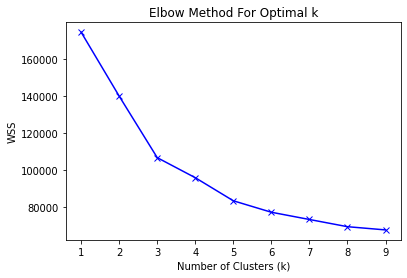

In [14]:
############## estimate n_clusters #####################################
# Define a range of cluster numbers to try
clusters = range(1,10)

# Initialize an array to store the WSS values for each cluster
wss_values = []

# Calculate the WSS values for each cluster
for k in clusters:
    kmeans_model = KMeans(n_clusters=k).fit(X)
    wss_values.append(sum(np.min(cdist(X, kmeans_model.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the WSS values against the number of clusters
plt.plot(clusters, wss_values, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WSS')
plt.title('Elbow Method For Optimal k')
plt.show()
num_clusters = 3             ##### specify num of minority data clusters, play around with diff values
##########################################################################

In [ ]:
ensemble_performance( X, y, dataset_name, 'ensemble', reduced_clf_list, reduced_clf_names)
kmeans_bsmote( X, y, dataset_name, 'cluster_bsmote', clf_list, clf_names, n_clusters = 3  )
raw_performance( X, y, dataset_name, 'raw', clf_list, clf_names)
raw_performance( X, y, dataset_name, 'wtd', clf_list_wtd, clf_names_wtd)
for type_ in list(methods.keys()):
    resampled_performance( X, y, dataset_name, type_, methods, clf_list, clf_names )

0:	learn: 0.9481517	total: 32.6ms	remaining: 32.5s
1:	learn: 0.9513539	total: 66ms	remaining: 33s
2:	learn: 0.9515347	total: 100ms	remaining: 33.4s
3:	learn: 0.9540414	total: 132ms	remaining: 32.9s
4:	learn: 0.9542950	total: 165ms	remaining: 32.9s
5:	learn: 0.9544722	total: 199ms	remaining: 32.9s
6:	learn: 0.9552727	total: 235ms	remaining: 33.3s
7:	learn: 0.9553019	total: 270ms	remaining: 33.5s
8:	learn: 0.9561283	total: 303ms	remaining: 33.3s
9:	learn: 0.9567302	total: 335ms	remaining: 33.2s
10:	learn: 0.9570338	total: 370ms	remaining: 33.3s
11:	learn: 0.9578225	total: 404ms	remaining: 33.3s
12:	learn: 0.9583770	total: 438ms	remaining: 33.2s
13:	learn: 0.9585694	total: 475ms	remaining: 33.5s
14:	learn: 0.9584865	total: 509ms	remaining: 33.5s
15:	learn: 0.9587649	total: 545ms	remaining: 33.5s
16:	learn: 0.9589887	total: 580ms	remaining: 33.5s
17:	learn: 0.9590901	total: 614ms	remaining: 33.5s
18:	learn: 0.9589333	total: 650ms	remaining: 33.6s
19:	learn: 0.9593721	total: 684ms	remaining

165:	learn: 0.9873548	total: 6.63s	remaining: 33.3s
166:	learn: 0.9875059	total: 6.67s	remaining: 33.3s
167:	learn: 0.9875689	total: 6.71s	remaining: 33.2s
168:	learn: 0.9876796	total: 6.75s	remaining: 33.2s
169:	learn: 0.9877817	total: 6.79s	remaining: 33.1s
170:	learn: 0.9877975	total: 6.82s	remaining: 33.1s
171:	learn: 0.9879157	total: 6.86s	remaining: 33s
172:	learn: 0.9880338	total: 6.9s	remaining: 33s
173:	learn: 0.9881284	total: 6.94s	remaining: 33s
174:	learn: 0.9882382	total: 6.98s	remaining: 32.9s
175:	learn: 0.9883330	total: 7.02s	remaining: 32.9s
176:	learn: 0.9883807	total: 7.05s	remaining: 32.8s
177:	learn: 0.9884677	total: 7.09s	remaining: 32.8s
178:	learn: 0.9885389	total: 7.13s	remaining: 32.7s
179:	learn: 0.9886652	total: 7.17s	remaining: 32.7s
180:	learn: 0.9887518	total: 7.21s	remaining: 32.6s
181:	learn: 0.9888461	total: 7.24s	remaining: 32.5s
182:	learn: 0.9889788	total: 7.28s	remaining: 32.5s
183:	learn: 0.9890024	total: 7.32s	remaining: 32.5s
184:	learn: 0.98908

328:	learn: 0.9966906	total: 13.4s	remaining: 27.3s
329:	learn: 0.9966983	total: 13.4s	remaining: 27.2s
330:	learn: 0.9967139	total: 13.4s	remaining: 27.2s
331:	learn: 0.9967449	total: 13.5s	remaining: 27.1s
332:	learn: 0.9967994	total: 13.5s	remaining: 27.1s
333:	learn: 0.9967994	total: 13.6s	remaining: 27s
334:	learn: 0.9967994	total: 13.6s	remaining: 27s
335:	learn: 0.9967994	total: 13.6s	remaining: 26.9s
336:	learn: 0.9967994	total: 13.7s	remaining: 26.9s
337:	learn: 0.9968538	total: 13.7s	remaining: 26.8s
338:	learn: 0.9968538	total: 13.7s	remaining: 26.8s
339:	learn: 0.9968694	total: 13.8s	remaining: 26.7s
340:	learn: 0.9968617	total: 13.8s	remaining: 26.7s
341:	learn: 0.9968772	total: 13.8s	remaining: 26.6s
342:	learn: 0.9968849	total: 13.9s	remaining: 26.6s
343:	learn: 0.9969082	total: 13.9s	remaining: 26.5s
344:	learn: 0.9969160	total: 14s	remaining: 26.5s
345:	learn: 0.9969314	total: 14s	remaining: 26.5s
346:	learn: 0.9969624	total: 14s	remaining: 26.4s
347:	learn: 0.9969469	

491:	learn: 0.9988158	total: 20.2s	remaining: 20.8s
492:	learn: 0.9988158	total: 20.2s	remaining: 20.8s
493:	learn: 0.9988390	total: 20.3s	remaining: 20.8s
494:	learn: 0.9988313	total: 20.3s	remaining: 20.7s
495:	learn: 0.9988390	total: 20.4s	remaining: 20.7s
496:	learn: 0.9988468	total: 20.4s	remaining: 20.6s
497:	learn: 0.9988700	total: 20.4s	remaining: 20.6s
498:	learn: 0.9988700	total: 20.5s	remaining: 20.5s
499:	learn: 0.9988700	total: 20.5s	remaining: 20.5s
500:	learn: 0.9988777	total: 20.5s	remaining: 20.5s
501:	learn: 0.9988777	total: 20.6s	remaining: 20.4s
502:	learn: 0.9989087	total: 20.6s	remaining: 20.4s
503:	learn: 0.9989087	total: 20.7s	remaining: 20.3s
504:	learn: 0.9989164	total: 20.7s	remaining: 20.3s
505:	learn: 0.9989319	total: 20.7s	remaining: 20.2s
506:	learn: 0.9989397	total: 20.8s	remaining: 20.2s
507:	learn: 0.9989242	total: 20.8s	remaining: 20.2s
508:	learn: 0.9989242	total: 20.8s	remaining: 20.1s
509:	learn: 0.9989397	total: 20.9s	remaining: 20.1s
510:	learn: 

653:	learn: 0.9993809	total: 26.6s	remaining: 14.1s
654:	learn: 0.9993809	total: 26.6s	remaining: 14s
655:	learn: 0.9993809	total: 26.7s	remaining: 14s
656:	learn: 0.9993886	total: 26.7s	remaining: 13.9s
657:	learn: 0.9993886	total: 26.7s	remaining: 13.9s
658:	learn: 0.9993886	total: 26.8s	remaining: 13.9s
659:	learn: 0.9993886	total: 26.8s	remaining: 13.8s
660:	learn: 0.9993886	total: 26.8s	remaining: 13.8s
661:	learn: 0.9993964	total: 26.9s	remaining: 13.7s
662:	learn: 0.9993964	total: 27s	remaining: 13.7s
663:	learn: 0.9993964	total: 27s	remaining: 13.7s
664:	learn: 0.9993964	total: 27s	remaining: 13.6s
665:	learn: 0.9993964	total: 27.1s	remaining: 13.6s
666:	learn: 0.9993964	total: 27.1s	remaining: 13.5s
667:	learn: 0.9993964	total: 27.1s	remaining: 13.5s
668:	learn: 0.9993964	total: 27.2s	remaining: 13.4s
669:	learn: 0.9993964	total: 27.2s	remaining: 13.4s
670:	learn: 0.9993964	total: 27.3s	remaining: 13.4s
671:	learn: 0.9993964	total: 27.3s	remaining: 13.3s
672:	learn: 0.9993964	

816:	learn: 0.9995589	total: 32.5s	remaining: 7.29s
817:	learn: 0.9995589	total: 32.6s	remaining: 7.25s
818:	learn: 0.9995589	total: 32.6s	remaining: 7.21s
819:	learn: 0.9995589	total: 32.6s	remaining: 7.16s
820:	learn: 0.9995589	total: 32.7s	remaining: 7.12s
821:	learn: 0.9995589	total: 32.7s	remaining: 7.08s
822:	learn: 0.9995589	total: 32.7s	remaining: 7.04s
823:	learn: 0.9995589	total: 32.8s	remaining: 7s
824:	learn: 0.9995589	total: 32.8s	remaining: 6.96s
825:	learn: 0.9995589	total: 32.8s	remaining: 6.92s
826:	learn: 0.9995589	total: 32.9s	remaining: 6.88s
827:	learn: 0.9995589	total: 32.9s	remaining: 6.83s
828:	learn: 0.9995589	total: 32.9s	remaining: 6.79s
829:	learn: 0.9995589	total: 33s	remaining: 6.75s
830:	learn: 0.9995589	total: 33s	remaining: 6.71s
831:	learn: 0.9995589	total: 33s	remaining: 6.67s
832:	learn: 0.9995589	total: 33.1s	remaining: 6.63s
833:	learn: 0.9995589	total: 33.1s	remaining: 6.59s
834:	learn: 0.9995589	total: 33.1s	remaining: 6.55s
835:	learn: 0.9995589

979:	learn: 0.9996286	total: 38.6s	remaining: 788ms
980:	learn: 0.9996286	total: 38.6s	remaining: 749ms
981:	learn: 0.9996286	total: 38.7s	remaining: 709ms
982:	learn: 0.9996286	total: 38.7s	remaining: 670ms
983:	learn: 0.9996286	total: 38.8s	remaining: 630ms
984:	learn: 0.9996286	total: 38.8s	remaining: 591ms
985:	learn: 0.9996363	total: 38.9s	remaining: 552ms
986:	learn: 0.9996363	total: 38.9s	remaining: 512ms
987:	learn: 0.9996363	total: 38.9s	remaining: 473ms
988:	learn: 0.9996363	total: 39s	remaining: 434ms
989:	learn: 0.9996363	total: 39s	remaining: 394ms
990:	learn: 0.9996363	total: 39.1s	remaining: 355ms
991:	learn: 0.9996363	total: 39.1s	remaining: 315ms
992:	learn: 0.9996363	total: 39.1s	remaining: 276ms
993:	learn: 0.9996363	total: 39.2s	remaining: 236ms
994:	learn: 0.9996363	total: 39.2s	remaining: 197ms
995:	learn: 0.9996363	total: 39.2s	remaining: 158ms
996:	learn: 0.9996363	total: 39.3s	remaining: 118ms
997:	learn: 0.9996518	total: 39.3s	remaining: 78.8ms
998:	learn: 0.9

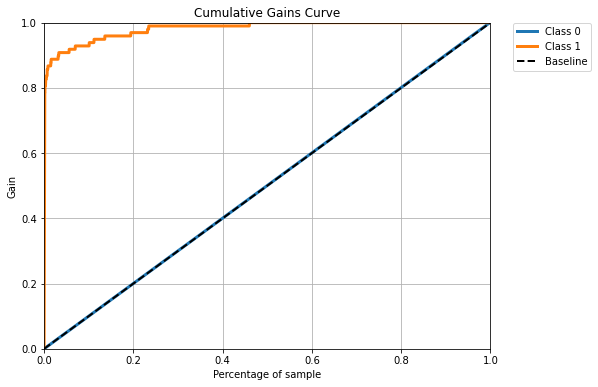

In [18]:
# plot Cumulative gain and lift for Belgium Credit Data
import scikitplot as skplt   ########### install this package

clf = clf_list[5] ############# pick classifier from list of classifiers
path_to_data = 'D:/data-sets-and-code/creditcard.csv'
df = pd.read_csv(path_to_data)
X = df.drop(['Class'], axis = 1)
y = df['Class']

X_train, X_test, y_train, y_test  = train_test_split(X, y, stratify=y, test_size=0.2, random_state = 0)
pipe =  imbpipeline(steps = [('mthod', SMOTE( sampling_strategy = 1/ir, random_state=2117 )), ('rf',clf)])
pipe.fit(X_train, y_train)
a = skplt.metrics.plot_cumulative_gain(y_test, pipe.predict_proba(X_test), figsize=(8, 6))
a.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

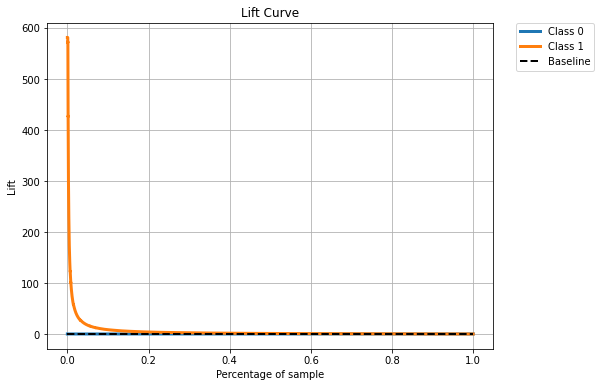

In [19]:
a = skplt.metrics.plot_lift_curve(y_test, pipe.predict_proba(X_test), figsize=(8, 6))
a.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

550
[99.98241418120428, 61.224489795918366, 78.23919923419734, 71.42857142857143, 85.71428571428571, 93.13193024818257, 62.240163468570074]
500
[99.98241418120428, 64.28571428571429, 80.17132225209241, 73.68421052631578, 86.3013698630137, 93.07009276698861, 62.910969154532815]
450
[99.9806555993247, 69.38775510204081, 83.29125551741569, 76.8361581920904, 86.07594936708861, 93.52418373089246, 65.41090645184728]
400
[99.9806555993247, 68.36734693877551, 82.67655150358692, 76.13636363636363, 85.8974358974359, 93.38206160348213, 63.936647204104304]
350
[99.98417276308385, 69.38775510204081, 83.2927205328593, 77.71428571428571, 88.31168831168831, 93.51844142271429, 66.25749302832806]
300
[99.97713843556556, 72.44897959183673, 85.10723625032438, 78.02197802197803, 84.52380952380952, 93.65218336912704, 65.39886013633793]
250
[99.97713843556556, 73.46938775510205, 85.7044873409093, 78.68852459016394, 84.70588235294117, 93.80471343011038, 67.37854227644509]
200
[99.94020821609453, 73.4693877551

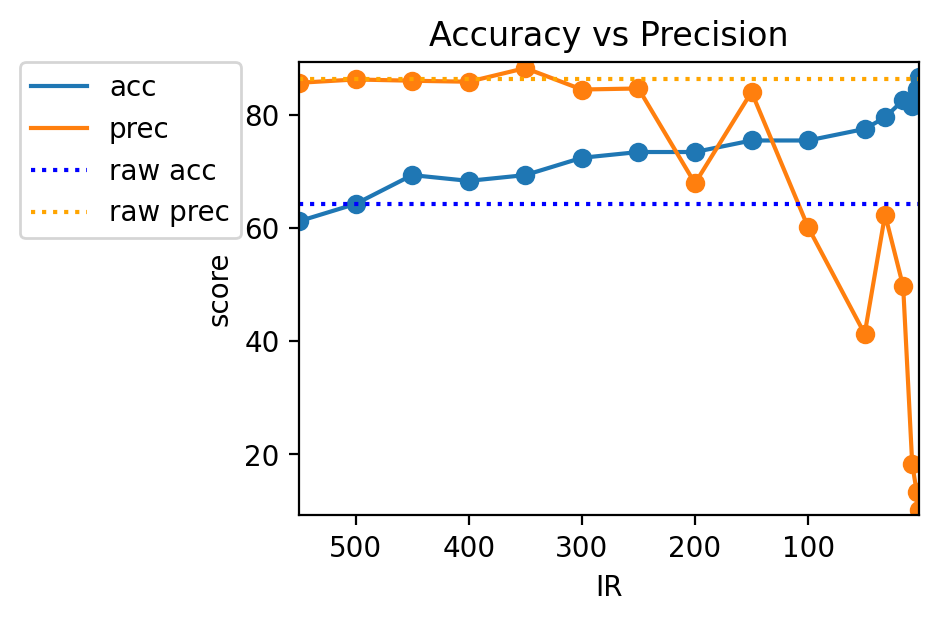

In [22]:
# Accuracy vs precision plots for Belgium Credit

clf = clf_list[4] ######### choose classifier
ir_values = [i for i in range(550, 2, -50)] + [32, 16, 8, 4, 2] ### specify ir's 
acc1_val = []
prec1_val = []
for ir in ir_values:
    print(ir)
    pipe =  imbpipeline(steps = [('mthod', SMOTE( sampling_strategy = 1/ir, random_state=2117 )), ('rf',clf)])
    pipe.fit(X_train, y_train)
    predictions = pipe.predict(X_test)
    prob_predictions = pipe.predict_proba(X_test)[:,1]
    a = compute_metrics(y_test, predictions, prob_predictions)
    print(a)
    acc1_val.append(a[1])
    prec1_val.append(a[4])

#baseline raw
pipe =  Pipeline(steps = [('rf',clf)])
pipe.fit(X_train, y_train)
predictions = pipe.predict(X_test)
prob_predictions = pipe.predict_proba(X_test)[:,1]
a = compute_metrics(y_test, predictions, prob_predictions)
print(a)
raw_acc1 = a[1]
raw_prec1 = a[4]

import matplotlib.pyplot as plt
# Create a figure and axes
fig, ax = plt.subplots(figsize=(4, 3), dpi=200)

plt.axis([max(ir_values), min(ir_values), min(acc1_val + prec1_val)-1, max(acc1_val + prec1_val)+1])

# Plot the first line chart
ax.plot(ir_values, acc1_val, label='acc')

# Plot the second line chart
ax.plot(ir_values, prec1_val, label='prec')

plt.axhline(y=raw_acc1, linestyle=':', label = 'raw acc', color = 'blue')
plt.axhline(y=raw_prec1, linestyle=':', label = 'raw prec', color = 'orange')

ax.legend(bbox_to_anchor=(-0.45, 1), loc='upper left', borderaxespad=0)

ax.set_xlabel('IR')
ax.set_ylabel('score')
ax.set_title('Accuracy vs Precision')

# Plot the first line chart
ax.scatter(ir_values, acc1_val, label='acc')

# Plot the second line chart
ax.scatter(ir_values, prec1_val, label='prec')

plt.show()